# Eliminating Animal Agriculture Would Negate 56 Percent of Anthropogenic Greenhouse Gas Emissions Through 2100

### Michael B. Eisen$^1$ and Patrick O. Brown$^2$

$^1$ Department of Molecular and Cell Biology, Howard Hughes Medical Institute, University of California, Berkeley, Berkeley, CA.  
$^2$ Impossible Foods, Redwood City, CA.  

## Abstract

We used public data on greenhouse-gas emissions and land use to evaluate the potential impact of eliminating animal agriculture on atmospheric greenhouse gas levels, and global warming potential. We first updated estimates of carbon dioxide, methane, and nitrous oxide emissions from livestock and livestock feed production. We used these data, along with recent estimates of the atmospheric carbon dioxide that could be converted by photosynthesis into perennial biomass on land currently engaged in animal agriculture, to develop models of net anthropogenic emissions under food-system scenarios ranging from “business as usual” to the complete elimination of animal agriculture. We then used simple simulations to project atmospheric levels of these three gases through the end of the century under each scenario. Using cumulative differences in radiative forcing as a measure of the impact of different diets, we found that a gradual transition over the next 15 years to a plant-only diet would have the same effect through the rest of the century as an annual reduction of 28 Gt of CO2 emissions. This would effectively negate 56 percent of global emissions at the current rate of 50 Gt CO2eq per year, with a net negation of 2,200 gigatonnes of CO2 emissions by the year 2100. The climate benefits would accrue rapidly - most in the first few decades, effectively pausing greenhouse-gas accumulation for 30 years. These results establish the replacement of animal agriculture as by far the most powerful option in our arsenal of climate-defense strategies, especially given the urgency of the climate threat. How to orchestrate such a shift to maximize its beneficial environmental, public health, food security, economic and social consequences and minimize potential harms should therefore be at the center of climate policy discussions.


### Load Python libraries

In [1]:
import pandas as pd

import numpy as np
from numpy import interp

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as mticker
import matplotlib.patches as patches

from scipy.interpolate import interp1d
from scipy.interpolate import splrep, splev
from scipy.stats import linregress

import fiona

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import textwrap as tw

import rasterio as rs
from rasterio.plot import show
import rasterio.mask

import xarray

encoding = "utf_8"

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Definitions

In [3]:
gases = ['CO2','CH4','N2O']
gas_units = {'CO2' : 'ppm','CH4' : 'ppb', 'N2O' : 'ppb'}

### Utility Functions

In [4]:
# convert a string to an int if it can be
# otherwise keep it a string

def stoi(s):
    try: 
        si = int(s)
        return si
    except ValueError:
        return s

# Estimating Animal Ag Emissions

### FAOSTAT Country Data

We need to use a consistent set of countries and country names. We use the FAOSTAT country list as our reference, and have accumulated a set of alternative names, punctuations and spellings from other datasets that we load here and use throughout.

In [5]:
country_group = pd.read_csv("FAOSTAT/FAOSTAT_Country_Group.csv",encoding = encoding)
fao_countries = list((pd.read_csv("Inputs/fao_countries.csv", encoding = encoding))['Area'].unique())

country_aliases = pd.read_csv("Inputs/country_aliases.csv",encoding = encoding)
country_alias_map = {}

for i,r in country_aliases.iterrows():
    country_alias_map[r['Alias']] = r['FAO Country']

for faoc in fao_countries:
    country_alias_map[faoc] = faoc

### Species and Production Emissions Data From Global GLEAM 2.0 

We use data from the United Nations Food and Agriculture Organization (FAO) Global Livestock Environmental Assessment Model [GLEAM](http://www.fao.org/gleam/resources/en/), version 2.0, to estimate gloabl emissions from animal agriculture. 

GLEAM is a modelling framework that simulates the interaction of activities and processes involved in livestock production and the environment. It was designed to allow policymakers to study the environmental consequences of changes in different steps of livestock supply chains. But we make use only of its baseline model of emissions broken down by species, product and region. 

We use the public data [available here]( http://www.fao.org/fileadmin/user_upload/gleam/docs/GLEAM_Data_public_release.xlsx).



In [6]:
# This is a lookup table to connect category, product and production process from GLEAM to species/product pairs

commodity_info = pd.DataFrame( data = 
    [
        ['Meat','buffalo_meat','Buffalo','All systems','Whole herd'],
        ['Meat','cattle_meat','Cattle','All systems','Whole herd'],
        ['Meat','chicken_meat','Chickens','All systems','Whole herd'],
        ['Meat','duck_meat','Chickens','All systems','Whole herd'], # no GLEAM data so use Chickens
        ['Meat','goat_meat','Goats', 'All systems','Whole herd'],
        ['Meat','sheep_meat','Sheep', 'All systems','Whole herd'],
        ['Meat','pig_meat','Pigs', 'All systems','Whole herd'],
        ['Milk','buffalo_milk','Buffalo','All systems','Dairy'],
        ['Milk','cow_milk','Cattle','All systems','Whole herd'],
        ['Milk','goat_milk','Goats','All systems','Whole herd'],
        ['Milk','sheep_milk','Sheep','All systems','Whole herd'],
        ['Eggs','eggs','Chickens','All systems','Whole herd']
    ],
    columns = ['Product Type','Category','Species','System','Type']
            
)

In [7]:
prods = ['Meat','Milk','Eggs']

gleam_var = {
    'Meat' : 'PROD: Meat - carcass weight', 
    'Milk' : 'PROD: Milk - fresh weight', 
    'Eggs' : 'PROD: Eggs - shell weight'
}

In [8]:
# GLEAM expresses gas-specific emission intensities in terms of emissions per unit protein
# These factors, which are derived from data in GLEAM, allow for conversion of protein units to FAO production units 
# carcass weight for meat
# liquid weight for milk
# shell weight for eggs

# use data from old version of GLEAM to get conversion from protein to production units

gleamall = pd.read_csv("GLEAM/GLEAM.csv", encoding=encoding)
df = pd.pivot_table(gleamall,index=['Species','System','Country','Type'],columns=['Variable'],aggfunc={'Value' : sum}).reset_index()
df.columns = df.columns = [c[0] for c in df.columns[0:4]] + [c[1] for c in df.columns[4:]]
df = df.groupby(['Species']).sum().reset_index()
df['CONV: Eggs'] = df['PROD: Eggs - shell weight']/df['PROD: Eggs - protein amount']
df['CONV: Milk'] = df['PROD: Milk - fresh weight']/df['PROD: Milk - protein amount']
df['CONV: Meat'] = df['PROD: Meat - carcass weight']/df['PROD: Meat - protein amount']
df[['Species'] + [c for c in df.columns if c.startswith('CONV')]]

data = []
for i,r in df.iterrows():
    for c in ['Eggs','Milk','Meat']:
        if r['CONV: %s' %c] > 0:
            data.append([r.Species,c,r['CONV: %s' %c]])
            
conversions = pd.DataFrame(data=data,columns=['Species','Commodity','Conversion'])
conversions = conversions.set_index(['Species','Commodity'])
conversions.loc[('Buffalo','Milk'),'Conversion'] = conversions.loc[('Cattle','Milk')]['Conversion']
conversions = conversions.reset_index()

In [9]:
conversions

,Species,Commodity,Conversion
0,Buffalo,Milk,29.656719
1,Buffalo,Meat,6.928637
2,Cattle,Milk,29.656719
3,Cattle,Meat,6.506834
4,Chickens,Eggs,8.064516
5,Chickens,Meat,7.017544
6,Goats,Milk,26.690530
7,Goats,Meat,7.440476
8,Pigs,Meat,7.616146
9,Sheep,Milk,16.485994


### GLEAM Emissions Intensity data

In [10]:
gleam2 =  pd.read_excel(open("GLEAM/GLEAM_Data_public_release.xlsx", 'rb'),sheet_name = "GLEAM_GRL", skiprows=2)

# harmonize  names

gleam2.loc[gleam2[gleam2.Species == "Buffaloes"].index,'Species'] = "Buffalo"
gleam2.loc[gleam2[gleam2.Species == "Chicken"].index,'Species'] = "Chickens"

# select products

gleam2 = gleam2[gleam2.Commodity.isin(prods)]
gleam2 = gleam2.merge(conversions,on=["Species","Commodity"],how="left")

for gas in gases:
    gleam2['EI_%s_perkg' % (gas)] = gleam2['Total %s' % gas] / (gleam2['Production'] * gleam2['Conversion'])
gleam2[(gleam2.Region == "Global") & (gleam2.System == "Aggregated")]
df = gleam2[(gleam2.Region == "Global") & (gleam2.System == "Aggregated")].copy()

# adjust CO2eq --> Gt (CO2) or Mt (CH4 and N2O)
for c in df:
    if 'CO2' in c and 'EI' not in c:
        df[c] = df[c] / 1E+12
        
    if 'CH4' in c and 'EI' not in c:
        df[c] = df[c] / (34 * 1E+9)
        
    if 'N2O' in c and 'EI' not in c:
        df[c] = df[c] / (298 * 1E+9)

### GLEAM Country -> Regions Mapping

This version of GLEAM only reports regionalized data. Would love to use country-specific data but they do not make it available and declined our request to share it.

In [11]:
gleam2_c = pd.read_excel(open("GLEAM/GLEAM_Data_public_release.xlsx", 'rb'),sheet_name = "COUNTRY_LIST", index_col=None, header=None, names=["Country"])

data = []
region = ""

for i,r in gleam2_c.iterrows():
    if r.Country[0:3] == "   ":
        data.append([region,r.Country[3:]])
    else:
        region = r.Country
        
gleam2_countries = pd.DataFrame(data=data,columns=['Region','Country'])

gleam2['Region'] = gleam2['Region'].str.upper()
gleam2c = gleam2_countries.merge(gleam2,on="Region",how='left')
gleam2c = gleam2c[gleam2c.System == "Aggregated"]

gleam2c['Country Mapped'] = gleam2c['Country'].map(country_alias_map)
gleam2c_countries = gleam2c['Country Mapped'].unique()

gleam2c = gleam2c[['Country Mapped','Species', 'System', 'Commodity', 'EI_CO2_perkg', 'EI_CH4_perkg', 'EI_N2O_perkg']]
gleam2c.columns = ['Area','Species', 'System', 'Product', 'EI_CO2_perkg', 'EI_CH4_perkg', 'EI_N2O_perkg']

### Load FAO Primary Production Data

In [12]:
datafile = "Inputs/FAOSTAT_production_categories.csv"
fao_production_categories = pd.read_csv(datafile,encoding = encoding)
        
datafile = "FAOSTAT/Filtered/Production_LivestockPrimary_E_All_Data_(Normalized).csv"

fao_livestock_primary = pd.read_csv(datafile,encoding = "latin_1")
    
year = np.max(fao_livestock_primary.Year.values)
fao_livestock_primary = fao_livestock_primary[
        (fao_livestock_primary.Area.isin(fao_countries)) 
        & (fao_livestock_primary.Year == year) 
        & (fao_livestock_primary.Element == 'Production' ) 
        & (fao_livestock_primary.Unit == "tonnes")]
fao_livestock_primary.Value = fao_livestock_primary.Value.astype('Int64')
fao_livestock_primary = fao_livestock_primary.merge(fao_production_categories, on = "Item")
fao_livestock_primary['Primary Production'] = fao_livestock_primary['Value'] * fao_livestock_primary['Category Weight']
fao_livestock_primary = fao_livestock_primary[['Area','Category','Primary Production']].groupby(['Area','Category']).sum().reset_index()

### Join GLEAM and FAO Livestock Data to Estimate Current Animal Ag Emissions

In [13]:
livestock_data = fao_livestock_primary.copy()

incols = list(livestock_data.columns)

# create columns for Emissions data
for gas in gases:
    livestock_data['Emissions|%s' % gas] = 0

livestock_data = livestock_data.merge(commodity_info,on="Category",how="left")
livestock_data = livestock_data.merge(gleam2c, 
            left_on=['Area','Product Type','Species'], 
            right_on=['Area','Product','Species'],
            how="left")

# GLEAM uses AR5 numbers for GWP
gwp = {
    'CO2' : 1,
    'CH4' : 34,
    'N2O' : 298
}

# scale from Gt --> Mt for CH4 and N2O

scale = {
    'CO2' : 1,
    'CH4' : 1000,
    'N2O' : 1000
}


for gas in gases:
    livestock_data['Emissions|%s' % gas] =  ( livestock_data['Primary Production'] 
    * livestock_data['EI_%s_perkg' % (gas)] 
    * scale[gas]
    / gwp[gas]
    / 1E+09 )

    
livestock_data = livestock_data[incols + ['Emissions|%s' % gas  for gas in gases]]

In [14]:
livestock_data.groupby('Category').sum()

,Primary Production,Emissions|CO2,Emissions|CH4,Emissions|N2O
Category,,,,
ass_meat,164977.0,0.0,0.0,0.0
buffalo_meat,4290212.0,0.02885,5.000432,0.198579
buffalo_milk,133752296.0,0.121331,10.872296,0.445477
camel_meat,685667.0,0.0,0.0,0.0
camel_milk,3111462.0,0.0,0.0,0.0
cattle_meat,68281663.0,0.615803,49.302813,2.412017
chicken_meat,123973557.0,0.440367,0.293461,0.52061
cow_milk,715871270.0,0.357411,37.680716,1.778157
duck_meat,7363110.0,0.036057,0.023576,0.049332


## Total Livestock Emissions

These numbers: 2.25 Gt CO2, 122 Mt CH4 and 7 Mt N2O are consistent with recently published work. 

In [15]:
livestock_data.groupby('Category').sum().sum()

Primary Production    1.304234e+09
Emissions|CO2         2.253190e+00
Emissions|CH4         1.227661e+02
Emissions|N2O         6.996565e+00
dtype: float64

### Estimate Species, Product and Country-Specific Land Use

We use average land use data from Figure 1 of (Poore and Nemecek, 2018) to estimate land use associated with different species and products. We use data for cattle meat for buffalo meat, and cow milk for milk from buffalo, goat and sheep. The data are reported in million $m^2$/year/(100g protein) except for milk which is reported in $m^2$/year/liter which we convert to $m^2$/year/(kg primary production) using conversion factors inferred from GLEAM. As above, we used data on domestic production and trade to convert tonnes of primary production equivalents to land use. 

In [16]:
animal_land_data = [
       ['cattle_meat', 1640.0, 6.506834],
       ['buffalo_meat', 1640.0, 6.928637],
       ['goat_meat', 1000.0, 7.440476],
       ['sheep_meat', 1850.0, 7.096728],
       ['pig_meat', 110.0, 7.616146],
       ['chicken_meat', 71.0, 7.017544],
       ['duck_meat', 71.0, 7.017544],
       ['cow_milk', 8.9, 1],
       ['buffalo_milk', 8.9, 1],
       ['goat_milk', 8.9, 1 ],
       ['sheep_milk', 8.9, 1],
       ['eggs', 57.0, 8.06],
]

animal_land = pd.DataFrame(data=animal_land_data,columns=['Category','land use protein','protein ratio'])

# the 1000 is kg --> tonne
# the 1E+12 if m2 --> Mkm2
    
animal_land['land use per tonne'] = (animal_land['land use protein'] / animal_land['protein ratio']) * 1000 / 1E+12
incols = list(livestock_data.columns)
livestock_data = livestock_data.merge(animal_land,on="Category",how='left')
livestock_data['Land Use'] = livestock_data['Primary Production'] * livestock_data['land use per tonne']
livestock_data = livestock_data[incols + ['Land Use']]

In [17]:
commodity_info_conversion = commodity_info.merge(conversions,left_on=['Species','Product Type'],right_on=['Species','Commodity'])
commodity_info_conversion = commodity_info_conversion[['Category','Species','Product Type','Conversion']]

livestock_data = livestock_data.merge(commodity_info_conversion,on="Category")
livestock_data['Protein Production'] = livestock_data['Primary Production'] / livestock_data['Conversion']
livestock_data['Emissions|CO2|Replacement'] = livestock_data['Protein Production'] * 1000 * 2.0 / 1E+12
livestock_data['Land Use|Replacement'] = livestock_data['Protein Production'] * 1000 * 8.0 / 1E+12
livestock_data.to_csv("Outputs/livestock_data.csv",index=False)

In [18]:
cols = ['Area', 'Category', 'Primary Production', 'Emissions|CO2',
       'Emissions|CH4', 'Emissions|N2O', 'Land Use', 'Protein Production', 'Emissions|CO2|Replacement',
       'Land Use|Replacement']

livestock_cat_data = livestock_data[cols].groupby('Category').sum(numeric_only=True)

### Start to Populate Emissions/Land Table

In [19]:
cols = ['Area', 'Category', 'Primary Production', 'Emissions|CO2',
       'Emissions|CH4', 'Emissions|N2O', 'Land Use', 'Protein Production', 'Emissions|CO2|Replacement',
       'Land Use|Replacement']

df = livestock_data[cols].set_index(['Area','Category']).stack().reset_index()
df.columns = ['Area','Category','Item','Animal Ag']
emland_cat = df.groupby(['Category','Item']).sum().reset_index()
emland_cat = emland_cat.set_index(['Category','Item'])
emland = df.groupby('Item').sum().reset_index()
emland = emland.set_index('Item')

## Emissions and Land Use of All Agriculture

In [20]:
datafile = "FAOSTAT/Filtered/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv"
fao_emissions = pd.read_csv(datafile,encoding = "latin_1")
fao_emissions = fao_emissions[fao_emissions.Area == "World"]
fao_emissions_pt = fao_emissions.pivot_table(index=['Item','Element','Unit'], columns=['Year'],aggfunc={'Value' : sum}).reset_index()
fao_emissions_pt.columns = [c[0] for c in fao_emissions_pt.columns[0:3]] + [c[1] for c in fao_emissions_pt.columns[3:]]
for y in [2018,2019]:
    fao_emissions_pt[y] = fao_emissions_pt[2000] + (y/2017) * (fao_emissions_pt[2017] - fao_emissions_pt[2000])
fao_emissions_pt = fao_emissions_pt.set_index(['Item','Element'])

In [21]:
emland ['All Ag'] = np.nan

emland.loc['Emissions|CO2','All Ag'] = fao_emissions_pt.loc[('Agriculture and related land use','CO2 emissions')][2019] / 1E+06
emland.loc['Emissions|CH4','All Ag'] = fao_emissions_pt.loc[('Agriculture total','CH4 emissions')][2019] / 1E+03
emland.loc['Emissions|N2O','All Ag'] = fao_emissions_pt.loc[('Agriculture total','N2O emissions')][2019] / 1E+03

# Direct from FAOSTAT
emland.loc['Land Use','All Ag'] = 4801370.2776 * 10 / 1000000

In [22]:
emland.loc['Emissions|CO2','Total'] = fao_emissions_pt.loc[('Total emissions with agricultural land use','CO2 emissions')][2018] / 1E+6
emland.loc['Emissions|CH4','Total'] = fao_emissions_pt.loc[('Total emissions with agricultural land use','CH4 emissions')][2018] / 1E+3
emland.loc['Emissions|N2O','Total'] = fao_emissions_pt.loc[('Total emissions with agricultural land use','N2O emissions')][2018] / 1E+3

## Replacement Diets

In [23]:
## segregate out total emissions to Non-Ag, Ag, and Other (mostly energy)

emland['No Ag'] = emland['Total'] - emland['All Ag']
emland['Non-Animal Ag'] = emland['All Ag'] - emland['Animal Ag']

## BAU diet equates food and all ag

emland['Food:BAU'] = emland['All Ag']

## Plant Only Diet assumes non-Animal Ag emissions are plant-based food
## Scales emissions by 20% to account for calories 

emland['Food:Replace'] = .25 * emland['Non-Animal Ag']
emland['Food:Plant'] = 1.25 * emland['Non-Animal Ag']

## Ag emissions are mostly from land use change, and this is already accounted for in Hayek's data
## So this is to avoid double counting

emland.loc['Emissions|CO2','Food:Plant'] = 0

In [24]:
## for specific products or groups of products scale by 
## total protein for diet
## and total land use for biomass recovery

data = []

for i,r in emland_cat.reset_index().groupby('Category'):
    rr = r.set_index('Item')
    primary_fraction = rr.loc['Primary Production']['Animal Ag'] / emland.loc['Primary Production']['Animal Ag']
    protein_fraction = rr.loc['Protein Production']['Animal Ag'] / emland.loc['Protein Production']['Animal Ag']
    land_fraction = rr.loc['Land Use']['Animal Ag'] / emland.loc['Land Use']['Animal Ag']
    data.append([i,primary_fraction,protein_fraction,land_fraction])

df = emland_cat.reset_index()

groups = {
    'Bovid' : ['cattle_meat','cow_milk','buffalo_meat','buffalo_milk'],
    'Ruminant' : ['cattle_meat','buffalo_meat','goat_meat','sheep_meat','cow_milk','buffalo_milk','goat_milk','sheep_milk'],
    'Ruminant Meat' : ['cattle_meat','buffalo_meat','goat_meat','sheep_meat'],
    'Ruminant Milk' : ['cow_milk','buffalo_milk','goat_milk','sheep_milk']
}

for group in groups:
    r = df[df.Category.isin(groups[group])]
    rr = r.set_index('Item')
    primary_fraction = rr.loc['Primary Production']['Animal Ag'].sum() / emland.loc['Primary Production']['Animal Ag'].sum()
    protein_fraction = rr.loc['Protein Production']['Animal Ag'].sum() / emland.loc['Protein Production']['Animal Ag'].sum()
    land_fraction = rr.loc['Land Use']['Animal Ag'].sum() / emland.loc['Land Use']['Animal Ag'].sum()
    data.append([group,primary_fraction,protein_fraction,land_fraction])

cat_fractions = pd.DataFrame(data=data,columns=['Category','Primary Fraction','Protein Fraction','Land Fraction']).set_index('Category')

In [25]:
cat_fractions

,Primary Fraction,Protein Fraction,Land Fraction
Category,,,
buffalo_meat,0.003303,0.007075,0.030747
buffalo_milk,0.102987,0.051529,0.036043
cattle_meat,0.052576,0.119897,0.521088
chicken_meat,0.095458,0.201845,0.037978
cow_milk,0.551211,0.275794,0.192911
duck_meat,0.005669,0.011988,0.002256
eggs,0.068091,0.125286,0.018936
goat_meat,0.004811,0.009595,0.025427
goat_milk,0.015331,0.008523,0.005365


In [26]:
livestock_cat_data

,Primary Production,Emissions|CO2,Emissions|CH4,Emissions|N2O,Land Use,Protein Production,Emissions|CO2|Replacement,Land Use|Replacement
Category,,,,,,,,
buffalo_meat,4290212.0,0.02885,5.000432,0.198579,1.015488,619200.03918,0.001238,0.004954
buffalo_milk,133752296.0,0.121331,10.872296,0.445477,1.190395,4510016.642341,0.00902,0.03608
cattle_meat,68281663.0,0.615803,49.302813,2.412017,17.209895,10493838.757487,0.020988,0.083951
chicken_meat,123973557.0,0.440367,0.293461,0.52061,1.254302,17666231.8725,0.035332,0.14133
cow_milk,715871270.0,0.357411,37.680716,1.778157,6.371254,24138586.31237,0.048277,0.193109
duck_meat,7363110.0,0.036057,0.023576,0.049332,0.074496,1049243.175,0.002098,0.008394
eggs,88431696.0,0.221156,0.574015,0.353017,0.625385,10965530.304,0.021931,0.087724
goat_meat,6248372.0,0.020656,3.340025,0.113621,0.839781,839781.1968,0.00168,0.006718
goat_milk,19910379.0,0.010325,1.743089,0.063117,0.177202,745971.658768,0.001492,0.005968


In [27]:
emland

,Animal Ag,All Ag,Total,No Ag,Non-Animal Ag,Food:BAU,Food:Replace,Food:Plant
Item,,,,,,,,
Emissions|CH4,122.766107,142.119577,367.959165,225.839588,19.353469,142.119577,4.838367,24.191837
Emissions|CO2,2.25319,4.531875,41.231054,36.699179,2.278685,4.531875,0.569671,0.0
Emissions|CO2|Replacement,0.175048,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Emissions|N2O,6.996565,7.828124,10.815596,2.987472,0.831559,7.828124,0.20789,1.039449
Land Use,33.026854,48.013703,NaN,NaN,14.986848,48.013703,3.746712,18.73356
Land Use|Replacement,0.700191,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Primary Production,1298725315.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Protein Production,87523915.605346,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
for cat in [c for c in list(cat_fractions.index) if c not in groups]:
    cid = 'Food:No:%s' % cat
    emland[cid] = 0
    for gas in ['CH4','N2O']:
        emland.loc['Emissions|%s' % gas,cid] = emland.loc['Emissions|%s' % gas]['Food:BAU'] - emland_cat.loc[cat,'Emissions|%s' % gas]['Animal Ag']
        emland.loc['Emissions|%s' % gas,cid] += cat_fractions.loc[cat]['Protein Fraction'] * emland.loc['Emissions|%s' % gas]['Food:Replace']
    gas = "CO2"
    emland.loc['Emissions|%s' % gas,cid] = emland.loc['Emissions|%s' % gas]['Food:BAU'] - cat_fractions.loc[cat]['Land Fraction'] * emland.loc['Emissions|CO2']['Animal Ag']
    
for group in groups:
    cid = 'Food:No:%s' % group
    emland[cid] = 0
    for gas in ['CH4','N2O']:
        emland.loc['Emissions|%s' % gas,cid] = emland.loc['Emissions|%s' % gas]['Food:BAU']
        for cat in groups[group]:
            emland.loc['Emissions|%s' % gas,cid] -= emland_cat.loc[cat,'Emissions|%s' % gas]['Animal Ag']
            emland.loc['Emissions|%s' % gas,cid] += cat_fractions.loc[cat]['Protein Fraction'] * emland.loc['Emissions|%s' % gas]['Food:Replace']
    gas = "CO2"
    emland.loc['Emissions|%s' % gas,cid] = emland.loc['Emissions|%s' % gas]['Food:BAU']
    for cat in groups[group]:
        emland.loc['Emissions|%s' % gas,cid] -= cat_fractions.loc[cat]['Land Fraction'] * emland.loc['Emissions|CO2']['Animal Ag']


##  Radiative Forcing 

Radiative forcing (RF) is defined as the difference between solar irradiance absorbed by the Earth and energy radiated back to space. RF combines the warming influence of difference gases together into a single number. It is measured in units of $Wm^{-2}$.

Increasing positive values of RF mean Earth is receiving correspondingly more incoming energy from sunlight than it radiates to space, causing increased warming. Strategies to mitigate global warming are often expressed in terms of RF targets.

Following [MAGICC](http://wiki.magicc.org/index.php?title=Radiative_Forcing) and IPCC AR5, we use the formula for Radiative Forcings as described in [Myhre et al. 1998](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/98GL01908) and [Ramaswamy et al., 2001](https://www.ipcc.ch/site/assets/uploads/2018/03/TAR-06.pdf).

For atmospheric concentrations of ${\rm CO_{2}}$ of ${\rm C}$ ppm, ${\rm CH_{4}}$ of ${\rm M}$ ppb, ${\rm N_{2}O}$ of ${\rm N}$ ppb. 

$\Delta F = \Delta F_{\rm CO_2}+\Delta F_{\rm CH_4}+\Delta F_{\rm N_{2}O}$ 

where:  

${\rm C_0}, {\rm M_0}, {\rm N_0}$ are the preindustrial concentrations of ${\rm CO_{2}}$ in ppm, ${\rm CH_{4}}$ in ppb, ${\rm N_{2}O}$ in ppb. 

$\Delta F_{\rm CO_2}=\alpha_{\rm CO_2}{\rm ln} (\rm C/C_0)$ 

$\Delta F_{\rm CH_4} = \alpha_{\rm CH_4}((1+\beta_{\rm CH_4})(\sqrt{\rm M}-\sqrt{\rm M_0})-f({\rm M},{\rm N_0})-f({\rm M_0},{\rm N_0}))$

$\Delta F_{\rm N_2O} = \alpha_{\rm N_2O}(\sqrt{\rm N}-\sqrt{\rm N_0}-f({\rm M_0},{\rm N})-f({\rm M_0},{\rm N_0})$

$f(\rm M,N)=0.47{\rm ln}\,(1+0.6356(\frac{\rm MN}{10^6})^{0.75}+0.007\frac{\rm M}{10^3}(\frac{\rm MN}{10^6})^{1.52})$

$\alpha_{\rm CO_2}=5.35$

$\alpha_{\rm CH_4}=0.036$

$\beta_{\rm CH_4}=0.15$

$\alpha_{\rm N_{2}O}=0.12$


In [29]:
def F_MAGICC(M,N):
    F = 0.47 * np.log(1 + 0.6356 * np.power(M*N/1E6,0.75) + 0.007 * (M/1E3) * np.power(M*N/1E6,1.52))
    return F
    
def RF_MAGICC(C,M,N):
    
    C0 = 278
    M0 = 700
    N0 = 270
    
    AC = 5.35
    AM = 0.036
    AN = 0.12
    
    beta = 0.15
    
    rf_co2 = AC*np.log(C/C0) 
    rf_ch4 = AM*((1+beta) * (np.sqrt(M) - np.sqrt(M0)) - F_MAGICC(M,N0) - F_MAGICC(M0,N0))
    rf_n2o = AN*(np.sqrt(N) - np.sqrt(N0) - F_MAGICC(M0,N) - F_MAGICC(M0,N0))
    
    rf = rf_co2 + rf_ch4 + rf_n2o
    
    return(rf_co2,rf_ch4,rf_n2o,rf)

def RF_AR5(C,M,N):
        
    C0 = 278
    M0 = 772
    N0 = 270

    C2011 = 0
    M2011 = 0
    N2011 = 0

    DC = (C2011 - C0)
    DM = (M2011 - M0)
    DN = (N2011 - N0)
    
    rf_ar5_CO2 = 1.68 * (C - C0) / DC
    rf_ar5_CH4 = 0.97 * (M - M0) / DM
    rf_ar5_N2O = 0.17 * (N - N0) / DN

## Cross-check RF Calculation Against MAGICC Output in SSP/IAMs

In [30]:
ssp_iam = pd.read_csv("SSP/SSP_IAM_V2_201811.csv/SSP_IAM_V2_201811.csv")
iamc = ssp_iam.set_index(list(ssp_iam.columns[0:5]))
df = pd.DataFrame(data=iamc.stack()).reset_index()
df.columns = ['Model','Scenario','Region','Variable','Unit','Year','Value']
dfp = pd.pivot_table(df,index=['Model','Scenario','Region','Year'],columns='Variable',aggfunc={'Value' : sum}).reset_index()
dfp.columns = list([c[0] for c in dfp.columns[0:4]]) + list([c[1] for c in dfp.columns[4:]])

In [31]:
dfp[['Year','Diagnostics|MAGICC6|Forcing']].groupby('Year').mean()

,Diagnostics|MAGICC6|Forcing
Year,
2005,1.870916
2010,2.136852
2020,2.640882
2030,3.094993
2040,3.435627
2050,3.683554
2060,3.868349
2070,4.018185
2080,4.144272


In [32]:
ssp_iam

,MODEL,SCENARIO,REGION,VARIABLE,UNIT,2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
0,AIM/CGE,SSP1-19,R5.2ASIA,Agricultural Demand|Crops,million t DM/yr,1045.142000,1127.873000,1274.294300,1617.362100,2733.721400,3175.503300,3783.437000,4130.262300,4079.700700,4077.817300,3991.996200
1,AIM/CGE,SSP1-19,R5.2ASIA,Agricultural Demand|Crops|Energy,million t DM/yr,0.000000,5.213500,27.072600,347.469100,1682.109200,2231.522500,3050.279500,3573.898200,3627.846200,3759.638000,3801.932300
2,AIM/CGE,SSP1-19,R5.2ASIA,Agricultural Demand|Livestock,million t DM/yr,85.998500,94.108500,107.896700,118.393500,125.901500,129.205500,128.101400,124.238400,118.040900,110.108300,100.669400
3,AIM/CGE,SSP1-19,R5.2ASIA,Agricultural Production|Crops|Energy,million t DM/yr,0.000000,0.000000,3.800700,63.017800,325.246800,436.832700,603.200500,710.315400,722.693600,749.968500,759.058900
4,AIM/CGE,SSP1-19,R5.2ASIA,Agricultural Production|Crops|Non-Energy,million t DM/yr,1329.199400,1421.917300,1570.729300,1669.978400,1724.456200,1728.247300,1671.671900,1587.116700,1477.915700,1352.322500,1210.135600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84348,WITCH-GLOBIOM,SSP5-Baseline,World,Secondary Energy|Liquids,EJ/yr,149.790188,168.251549,215.013233,270.548475,337.128808,391.357912,429.167317,454.324455,461.336287,456.642409,419.919395
84349,WITCH-GLOBIOM,SSP5-Baseline,World,Secondary Energy|Liquids|Biomass,EJ/yr,2.288658,4.123196,3.162469,6.041929,11.314896,16.310899,29.528163,33.897456,38.180924,40.226044,42.084453
84350,WITCH-GLOBIOM,SSP5-Baseline,World,Secondary Energy|Liquids|Biomass|w/o CCS,EJ/yr,2.288658,4.123196,3.162469,6.041929,11.314896,16.310899,29.528163,33.897456,38.180924,40.226044,42.084453
84351,WITCH-GLOBIOM,SSP5-Baseline,World,Secondary Energy|Liquids|Oil,EJ/yr,87.162978,104.367457,138.715283,169.305761,201.845779,222.469380,226.492023,219.624004,200.193459,180.819032,153.616757


In [33]:
C = dfp['Diagnostics|MAGICC6|Concentration|CO2']
M = dfp['Diagnostics|MAGICC6|Concentration|CH4']
N = dfp['Diagnostics|MAGICC6|Concentration|N2O']

In [34]:
def RF_MAGICC_XC(C,M,N):
    
    C0 = 277.04
    M0 = 679
    N0 = 270.5
    
    AC = 5.35
    AM = 0.036
    AN = 0.12
    
    beta = 0 # reported numbers don't include correction
    
    rf_co2 = AC*np.log(C/C0) 
    rf_ch4 = AM*((1+beta) * (np.sqrt(M) - np.sqrt(M0)) - F_MAGICC(M,N0) - F_MAGICC(M0,N0))
    rf_n2o = AN*(np.sqrt(N) - np.sqrt(N0) - F_MAGICC(M0,N) - F_MAGICC(M0,N0))
    
    rf = rf_co2 + rf_ch4 + rf_n2o
    
    return(rf_co2,rf_ch4,rf_n2o,rf)

LRC,LRM,LRN,LR = RF_MAGICC_XC(C,M,N)
MRC = dfp['Diagnostics|MAGICC6|Forcing|CO2']
MRM = dfp['Diagnostics|MAGICC6|Forcing|CH4']
MRN = dfp['Diagnostics|MAGICC6|Forcing|N2O']
MRF = dfp['Diagnostics|MAGICC6|Forcing']
MR = MRC + MRM + MRN

Text(0, 0.5, 'LOCAL RF')

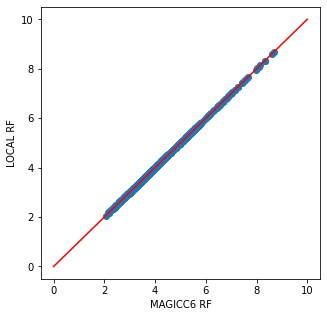

In [35]:
plt.figure(figsize=(5,5))
plt.scatter(MR,LR)
plt.plot(np.linspace(0,10,100),np.linspace(0,10,100),c='red')
plt.xlabel("MAGICC6 RF")
plt.ylabel("LOCAL RF")

## Train multivariate linear regression to fit effect of other gases

In [36]:
dfp['RF3'] = dfp['Diagnostics|MAGICC6|Forcing|CO2'] + dfp['Diagnostics|MAGICC6|Forcing|CH4'] + dfp['Diagnostics|MAGICC6|Forcing|N2O'] 
dfp['RFD'] = dfp['Diagnostics|MAGICC6|Forcing'] - dfp['RF3']

In [37]:
d = dfp[dfp.RF3 < 6][['Diagnostics|MAGICC6|Concentration|CO2','Diagnostics|MAGICC6|Concentration|CH4','Diagnostics|MAGICC6|Concentration|N2O','RFD']].dropna().values
X = d[:,0:3]
y = d[:,3]
rflr = LinearRegression()
rflr.fit(X,y)

def RF_cMAGICC(C,M,N):
    try:
        X_in = np.array([[x,M,N] for x in C])
    except:
        X_in = np.array([[C,M,N]])
    (x,y,z,r) = RF_MAGICC(C,M,N)
    d = rflr.predict(X_in)
    return  d + r

def RF_MAGICC_CORR(C,M,N):
    
    X_in = np.stack((C,M,N),axis=1)
    (x,y,z,r) = RF_MAGICC(C,M,N)
    d = rflr.predict(X_in)
    return  d + r

## Modeling Emission Scenarios and Atmospheric GHG Levels

In [38]:
model_years = np.arange(2020,2200)

halflife = {
    'CO2': 1000,
    'CH4': 9,
    'N2O': 115
}

annualdecay = {
    'CO2': 1,
    'CH4': np.power(.5,1/halflife['CH4']),
    'N2O': np.power(.5,1/halflife['N2O'])
}

nona = {
    'CO2' : 0,
    'CH4' : (1-annualdecay['CH4']) * 717.76,
    'N2O' : (1-annualdecay['N2O']) * 269.55
}

# adjusted to fit with MAGICC projections
nona_fit = {
    'CO2' : 0,
    'CH4' : 25,
    'N2O' : 1.0 # 1.63 fits historical data
}

to_atm = {
    'CO2' : .5,
    'CH4' : 1,
    'N2O' : 1
}

to_Mt = {
    'CO2' : 1000,
    'CH4' : 1,
    'N2O' : 1
}

pp_scale = {
    'CO2' : (1/1000),
    'CH4' : 1,
    'N2O' : 1
}

mw = {
    'CO2' : 44,
    'CH4' : 16,
    'N2O' : 44
}

pp_start = {
    'CO2': 409.819034,
    'CH4': 1863.93445,
    'N2O': 332.538751
}

cr = {
    'CO2' : 1,
    'CH4' : 0,
    'N2O' : 0,
}

# Amount of carbon Hayek et al. estimate would be fixed over 30 years with a transformation to a plant only diet

# Reported in gigatonnes C

c_oc = 216

# convert gigatonnes C to gigatonnes CO2

co2_oc = c_oc * 44 / 12

# Scenario Modeling

The core scenario model is simple:

#### Convert emissions to atmospheric levels

CH4 and N2O go straight to atmosphere, CO2 we assume 50% goes to sinks. This approach was confirmed with fits to historical data. The conversion factor is based on mass and number of moles of gas in atmosphere. 

#### Decay of $CH_4$ and $N_{2}O$

There is some variance in estimates for the atmospheric half-lives of $CH_4$ (range 9-12) and $N_{2}O$ (range 115-121). We went with the lower values because these fit historical data better but they do not have significant impacts on the overall conclusions.

#### Non-anthropogenic emissions

Following other models, we assume that there is a non-anthropogenic contribution from $CH_4$ and $N_{2}O$. The values used were determined by fits to historical data.

In [39]:
def RunScenarios(emissions,
                to_Mt = to_Mt,
                mw = mw,
                pp_scale = pp_scale,
                pp_start = pp_start,
                annualdecay = annualdecay,
                to_atm = to_atm,
                nona = nona_fit
                ):
    concentration = {}
    for gas in gases:
        p = emissions[gas] * to_Mt[gas] * 1.0E12 * (1/mw[gas]) * (1/1.8E11) * pp_scale[gas]
        a = np.zeros(len(emissions[gas]))
        a[0] = pp_start[gas]
        for i in range(1,len(a)):
            a[i] = a[i-1] * annualdecay[gas] + p[i-1] * to_atm[gas] + nona[gas]
        concentration[gas] = a
    return concentration

## setup scenarios

In [40]:
scenarios = pd.DataFrame(data=model_years,columns=['Year'])

aa_phaseout = 15
scenarios['aa_exponential_phaseout'] = np.clip( np.exp (-5 * np.power((scenarios.Year-2020)/aa_phaseout,3)),0,1)

co2_oc_burnin = 30

scenarios['CO2_recovery_elimination'] = 0
v = scenarios['CO2_recovery_elimination'].values
v[1] = 1
scenarios['CO2_recovery_elimination'] = co2_oc * np.convolve(v,np.ones(co2_oc_burnin) / co2_oc_burnin,mode='full')[0:len(v)]

v = scenarios['aa_exponential_phaseout'].values
scenarios['aa_exponential_phaseout_delta'] = np.append([0],v[:-1]-v[1:])

v = scenarios['aa_exponential_phaseout_delta']
scenarios['CO2_recovery_phaseout'] = co2_oc * np.convolve(v,np.ones(co2_oc_burnin) / co2_oc_burnin,mode='full')[0:len(v)]

co2_oc_burnin = 50

scenarios['CO2_slow_recovery_elimination'] = 0
v = scenarios['CO2_slow_recovery_elimination'].values
v[1] = 1
scenarios['CO2_slow_recovery_elimination'] = co2_oc * np.convolve(v,np.ones(co2_oc_burnin) / co2_oc_burnin,mode='full')[0:len(v)]
v = scenarios['aa_exponential_phaseout_delta']
scenarios['CO2_slow_recovery_phaseout'] = co2_oc * np.convolve(v,np.ones(co2_oc_burnin) / co2_oc_burnin,mode='full')[0:len(v)]

In [41]:
scenario_list = []

In [42]:
## BAU

scenario_list.append('BAU')

for gas in gases:
    scenarios['Emissions|%s|BAU' % gas] = emland.loc['Emissions|%s' % gas]['Total']

In [43]:
## Elimination Model

scenario_list.append('Elimination')

for gas in gases:
    scenarios['Emissions|%s|Elimination' % gas] = emland.loc['Emissions|%s' % gas]['No Ag'] + emland.loc['Emissions|%s' % gas]['Food:Plant']
    
scenarios['Emissions|CO2|Elimination'] -= scenarios['CO2_recovery_elimination'] 

In [44]:
## 15 Year Phaseout

scenario_list.append('Phaseout')

for gas in gases:
    scenarios['Emissions|%s|Phaseout' % gas] = emland.loc['Emissions|%s' % gas]['No Ag']
    scenarios['Emissions|%s|Phaseout' % gas] += scenarios['aa_exponential_phaseout'] * emland.loc['Emissions|%s' % gas]['Food:BAU']
    scenarios['Emissions|%s|Phaseout' % gas] += (1-scenarios['aa_exponential_phaseout']) * emland.loc['Emissions|%s' % gas]['Food:Plant']

scenarios['Emissions|CO2|Phaseout'] -= scenarios['CO2_recovery_phaseout'] 

In [45]:
## 15 Year Phaseout just CO2 emissions

scid = 'Phaseout_Breakdown_CO2'
scenario_list.append(scid)

for gas in ['CH4','N2O']:
    scenarios['Emissions|%s|%s' % (gas,scid)] = emland.loc['Emissions|%s' % gas]['Total']


for gas in ['CO2']:
    scenarios['Emissions|%s|%s' % (gas,scid)] = emland.loc['Emissions|%s' % gas]['No Ag']
    scenarios['Emissions|%s|%s' % (gas,scid)] += scenarios['aa_exponential_phaseout'] * emland.loc['Emissions|%s' % gas]['Food:BAU']
    scenarios['Emissions|%s|%s' % (gas,scid)] += (1-scenarios['aa_exponential_phaseout']) * emland.loc['Emissions|%s' % gas]['Food:Plant']

#scenarios['Emissions|CO2|%s' % scid] -= scenarios['CO2_recovery_phaseout'] 

In [46]:
## 15 Year Phaseout just CO2 & CH4 emissions

scid = 'Phaseout_Breakdown_CO2_CH4'
scenario_list.append(scid)

for gas in ['N2O']:
    scenarios['Emissions|%s|%s' % (gas,scid)] = emland.loc['Emissions|%s' % gas]['Total']


for gas in ['CH4','CO2']:
    scenarios['Emissions|%s|%s' % (gas,scid)] = emland.loc['Emissions|%s' % gas]['No Ag']
    scenarios['Emissions|%s|%s' % (gas,scid)] += scenarios['aa_exponential_phaseout'] * emland.loc['Emissions|%s' % gas]['Food:BAU']
    scenarios['Emissions|%s|%s' % (gas,scid)] += (1-scenarios['aa_exponential_phaseout']) * emland.loc['Emissions|%s' % gas]['Food:Plant']

#scenarios['Emissions|CO2|%s' % scid] -= scenarios['CO2_recovery_phaseout'] 

In [47]:
## 15 Year Phaseout just GHG emissions, no biomass recovery

scid = 'Phaseout_Breakdown_CO2_CH4_N2O'
scenario_list.append(scid)

for gas in ['N2O','CH4','CO2']:
    scenarios['Emissions|%s|%s' % (gas,scid)] = emland.loc['Emissions|%s' % gas]['No Ag']
    scenarios['Emissions|%s|%s' % (gas,scid)] += scenarios['aa_exponential_phaseout'] * emland.loc['Emissions|%s' % gas]['Food:BAU']
    scenarios['Emissions|%s|%s' % (gas,scid)] += (1-scenarios['aa_exponential_phaseout']) * emland.loc['Emissions|%s' % gas]['Food:Plant']

#scenarios['Emissions|CO2|%s' % scid] -= scenarios['CO2_recovery_phaseout'] 

In [48]:
## 15 Year Phaseout just CO2 biomass recovery, no emissions

scid = 'Phaseout_Breakdown_CR_Only'
scenario_list.append(scid)

for gas in ['CO2','CH4','N2O']:
    scenarios['Emissions|%s|%s' % (gas,scid)] = emland.loc['Emissions|%s' % gas]['Total']


scenarios['Emissions|CO2|%s' % scid] -= scenarios['CO2_recovery_phaseout'] 

In [49]:
## 50 Year Biomass Recovery


## Elimination

scenario_list.append('Elimination|Slow Recovery')

for gas in gases:
    scenarios['Emissions|%s|Elimination|Slow Recovery' % gas] = emland.loc['Emissions|%s' % gas]['No Ag'] + emland.loc['Emissions|%s' % gas]['Food:Plant']
    
scenarios['Emissions|CO2|Elimination|Slow Recovery'] -= scenarios['CO2_slow_recovery_elimination'] 


## Phaseout 

scenario_list.append('Phaseout|Slow Recovery')

for gas in gases:
    scenarios['Emissions|%s|Phaseout|Slow Recovery' % gas] = emland.loc['Emissions|%s' % gas]['No Ag']
    scenarios['Emissions|%s|Phaseout|Slow Recovery' % gas] += scenarios['aa_exponential_phaseout'] * emland.loc['Emissions|%s' % gas]['Food:BAU']
    scenarios['Emissions|%s|Phaseout|Slow Recovery' % gas] += (1-scenarios['aa_exponential_phaseout']) * emland.loc['Emissions|%s' % gas]['Food:Plant']
    
scenarios['Emissions|CO2|Phaseout|Slow Recovery'] -= scenarios['CO2_slow_recovery_phaseout'] 

In [50]:
## Elimination with No Replacement Diet

scenario_list.append('Elimination|No Replace')

for gas in gases:
    scenarios['Emissions|%s|Elimination|No Replace' % gas] = emland.loc['Emissions|%s' % gas]['Total'] - emland.loc['Emissions|%s' % gas]['Animal Ag']
      
scenarios['Emissions|CO2|Elimination|No Replace'] -= scenarios['CO2_recovery_elimination']  

In [51]:
## Eliminate and Phaseout of Product Categories

scenario_cats = list(cat_fractions.index)

for cat in scenario_cats:
    cid = 'Food:No:%s' % cat
    
    ## Elimination

    scenario_list.append('Elimination|%s' % cat)
    for gas in gases:
        scenarios['Emissions|%s|Elimination|%s' % (gas,cat)] = emland.loc['Emissions|%s' % gas]['No Ag'] + emland.loc['Emissions|%s' % gas][cid]
    
    scenarios['Emissions|CO2|Elimination|%s' % cat] -= cat_fractions.loc[cat]['Land Fraction'] * scenarios['CO2_recovery_elimination'] 
    
    ## Phaseout
    
    scenario_list.append('Phaseout|%s' % cat)
    for gas in gases:
        scenarios['Emissions|%s|Phaseout|%s' % (gas,cat)] = emland.loc['Emissions|%s' % gas]['No Ag'] 
        scenarios['Emissions|%s|Phaseout|%s' % (gas,cat)] += scenarios['aa_exponential_phaseout'] * emland.loc['Emissions|%s' % gas]['Food:BAU']
        scenarios['Emissions|%s|Phaseout|%s' % (gas,cat)] += (1-scenarios['aa_exponential_phaseout']) * emland.loc['Emissions|%s' % gas][cid]
     
    scenarios['Emissions|CO2|Phaseout|%s' % cat] -= cat_fractions.loc[cat]['Land Fraction'] * scenarios['CO2_recovery_phaseout'] 

In [52]:
## Hybrids of BAU and Elimination/Phaseout Models
## These are to look at timing of elimination

for year in np.arange(2040,2070,1):
    cid = 'Hybrid_Elimination_%d' % year
    scenario_list.append(cid)
    df = scenarios[scenarios.Year > year]
    for gas in gases:
        scenarios['Emissions|%s|%s' % (gas,cid)] = scenarios['Emissions|%s|Elimination' % (gas)]
        scenarios.loc[df.index,'Emissions|%s|%s' % (gas,cid)] = df['Emissions|%s|BAU' % gas]


for year in np.arange(2040,2070,1):
    cid = 'Hybrid_Phaseout_%d' % year
    scenario_list.append(cid)
    df = scenarios[scenarios.Year > year]
    for gas in gases:
        scenarios['Emissions|%s|%s' % (gas,cid)] = scenarios['Emissions|%s|Phaseout' % (gas)]
        scenarios.loc[df.index,'Emissions|%s|%s' % (gas,cid)] = df['Emissions|%s|BAU' % gas]
        
for year in np.arange(2030,2050,1):
    cid = 'Hybrid_Zero_Beginning_%d' % year
    scenario_list.append(cid)
    df = scenarios[scenarios.Year > year]
    for gas in gases:
        scenarios['Emissions|%s|%s' % (gas,cid)] = 0
        scenarios.loc[df.index,'Emissions|%s|%s' % (gas,cid)] = df['Emissions|%s|BAU' % gas]
        
for year in np.arange(2040,2100,1):
    cid = 'Hybrid_Zero_End_%d' % year
    scenario_list.append(cid)
    df = scenarios[scenarios.Year > year]
    for gas in gases:
        scenarios['Emissions|%s|%s' % (gas,cid)] = scenarios['Emissions|%s|BAU' % gas]
        scenarios.loc[df.index,'Emissions|%s|%s' % (gas,cid)] = 0


## Run Scenarios

In [53]:
for scen in scenario_list:
    em = {}
    for gas in gases:
        em[gas] = scenarios['Emissions|%s|%s' % (gas,scen)]

    p = RunScenarios(em)
    for gas in gases:
        scenarios['Concentration|%s|%s' % (gas,scen)] = p[gas]
        
    rf = RF_MAGICC(p['CO2'],p['CH4'],p['N2O'])
    scenarios['RF|%s' % scen] = rf[3]
    scenarios['RFD|%s' % scen] =  scenarios['RF|%s' % scen] -  scenarios['RF|BAU']
    scenarios['CRFD|%s' % scen] = np.cumsum(scenarios['RFD|%s' % scen].values) 
    
    rf = RF_MAGICC_CORR(p['CO2'],p['CH4'],p['N2O'])
    scenarios['RFC|%s' % scen] = rf
    scenarios['RFCD|%s' % scen] =  scenarios['RFC|%s' % scen] -  scenarios['RFC|BAU']
    scenarios['CRFCD|%s' % scen] = np.cumsum(scenarios['RFCD|%s' % scen].values)   

## Calibration Scenarios

We calculate an annualized CO2 equivalent for cumulative RF changes by comparison to scenarios in which we start with BAU and remove CO2 emissions in different levels and then do a calibration to observed RF differences.

In [54]:
calib_scenarios = pd.DataFrame(data=model_years,columns=['Year'])
calib_scenario_list = []


## BAU

calib_scenario_list.append('BAU')

for gas in gases:
    calib_scenarios['Emissions|%s|BAU' % gas] = emland.loc['Emissions|%s' % gas]['Total']


gtsteps = np.arange(1,70)

for i in gtsteps:
    scenid = 'BAU_m%02dGT' % i
    calib_scenario_list.append(scenid)
    for gas in gases:
        calib_scenarios['Emissions|%s|%s' % (gas,scenid)] = calib_scenarios['Emissions|%s|BAU' % gas]

    # account for 2020
    v = np.ones(len(calib_scenarios))
    v[0] = 0

    calib_scenarios['Emissions|CO2|%s' % scenid] = calib_scenarios['Emissions|CO2|BAU'] - v * i

mtsteps = np.arange(10,1000,10)

for i in mtsteps:
    scenid = 'BAU_m%04dMT' % i
    calib_scenario_list.append(scenid)
    for gas in gases:
        calib_scenarios['Emissions|%s|%s' % (gas,scenid)] = calib_scenarios['Emissions|%s|BAU' % gas]

    # account for 2020
    v = np.ones(len(calib_scenarios))
    v[0] = 0

    calib_scenarios['Emissions|CO2|%s' % scenid] = calib_scenarios['Emissions|CO2|BAU'] - v * i/1000

ktsteps = np.arange(100,1000,100)

for i in ktsteps:
    scenid = 'BAU_m%04dkT' % i
    calib_scenario_list.append(scenid)
    for gas in gases:
        calib_scenarios['Emissions|%s|%s' % (gas,scenid)] = calib_scenarios['Emissions|%s|BAU' % gas]

    # account for 2020
    v = np.ones(len(calib_scenarios))
    v[0] = 0

    calib_scenarios['Emissions|CO2|%s' % scenid] = calib_scenarios['Emissions|CO2|BAU'] - v * i/1000000



for scen in calib_scenario_list:
    em = {}
    for gas in gases:
        em[gas] = calib_scenarios['Emissions|%s|%s' % (gas,scen)]

    p = RunScenarios(em)
    for gas in gases:
        calib_scenarios['Concentration|%s|%s' % (gas,scen)] = p[gas]

    rf = RF_MAGICC(p['CO2'],p['CH4'],p['N2O'])
    calib_scenarios['RF|%s' % scen] = rf[3]
    calib_scenarios['RFD|%s' % scen] =  calib_scenarios['RF|%s' % scen] -  calib_scenarios['RF|BAU']
    calib_scenarios['CRFD|%s' % scen] = np.cumsum(calib_scenarios['RFD|%s' % scen].values) 

    rf = RF_MAGICC_CORR(p['CO2'],p['CH4'],p['N2O'])
    calib_scenarios['RFC|%s' % scen] = rf
    calib_scenarios['RFCD|%s' % scen] =  calib_scenarios['RFC|%s' % scen] -  calib_scenarios['RFC|BAU']
    calib_scenarios['CRFCD|%s' % scen] = np.cumsum(calib_scenarios['RFCD|%s' % scen].values)   

calib_scenarios = calib_scenarios.set_index('Year')

coc_calibrations = {
}

for year in np.arange(2025,2200):

    x = []
    y = []

    r = calib_scenarios.loc[year]
    for i in gtsteps:
        x.append(i)
        y.append(r['CRFD|BAU_m%02dGT' % i])
    for i in mtsteps:
        x.append(i/1000)
        y.append(r['CRFD|BAU_m%04dMT' % i])
    for i in ktsteps:
        x.append(i/1000000)
        y.append(r['CRFD|BAU_m%04dkT' % i])

    f = interp1d(y,x)
    pf = np.polyfit(y,x,2)
    z = np.poly1d(pf)

    x = []
    y = []

    r = calib_scenarios.loc[year]
    for i in gtsteps:
        x.append(i)
        y.append(r['CRFCD|BAU_m%02dGT' % i])
    for i in mtsteps:
        x.append(i/1000)
        y.append(r['CRFCD|BAU_m%04dMT' % i])
    for i in ktsteps:
        x.append(i/1000000)
        y.append(r['CRFCD|BAU_m%04dkT' % i])

    fc = interp1d(y,x)
    pfc = np.polyfit(y,x,2)
    zc = np.poly1d(pfc)

    coc_calibrations[year] = [f,pf,z,fc,pfc,zc]


In [55]:
scenarios = scenarios.set_index('Year')

## Apply calibration functions

In [56]:
def compute_aco2eq(s):
    r = []
    for year in s.index:
        if year in coc_calibrations:
            [f,pf,z,fc,pfc,zc] = coc_calibrations[year]
            try:
                v = f(s[year])
                r.append(float(v))
            except:
                v = z(s[year])
                r.append(float(v))
        else:
            r.append(0)    
    return r

def compute_aco2eqc(s):
    r = []
    for year in s.index:
        if year in coc_calibrations:
            [f,pf,z,fc,pfc,zc] = coc_calibrations[year]
            try:
                v = fc(s[year])
                r.append(float(v))
            except:
                v = zc(s[year])
                r.append(float(v))
        else:
            r.append(0)    
    return r

In [57]:
for scen in scenario_list:
    scenarios['ACO2EQ|%s' % scen] = compute_aco2eq(scenarios['CRFD|%s' % scen])
    scenarios['COC|%s' % scen] = (scenarios.index - 2021) * scenarios['ACO2EQ|%s' % scen]
    scenarios['ACO2EQC|%s' % scen] = compute_aco2eqc(scenarios['CRFCD|%s' % scen]) 
    scenarios['COCC|%s' % scen] = (scenarios.index - 2021) * scenarios['ACO2EQC|%s' % scen]
    

for scen in calib_scenario_list:
    calib_scenarios['ACO2EQ|%s' % scen] = compute_aco2eq(calib_scenarios['CRFD|%s' % scen])
    calib_scenarios['COC|%s' % scen] = (calib_scenarios.index - 2021) * calib_scenarios['ACO2EQ|%s' % scen]
    calib_scenarios['ACO2EQC|%s' % scen] = compute_aco2eqc(calib_scenarios['CRFCD|%s' % scen]) 
    calib_scenarios['COCC|%s' % scen] = (calib_scenarios.index - 2021) * calib_scenarios['ACO2EQC|%s' % scen]    

In [58]:
## 

ref_year = 2100
r = scenarios.loc[ref_year]

for scen in scenario_list:
    v = scenarios['RFD|%s' % scen].values
    scenarios['RFDI|%s' % scen] = np.append([0],v[:-1]-v[1:])
    scenarios['RY_RFDW|%s' % scen] = (scenarios['RFDI|%s' % scen] * (2101 - scenarios.index))/r['CRFD|%s' % scen]

In [59]:
## 

ref_year = 2100
r = calib_scenarios.loc[ref_year]

for scen in calib_scenario_list:
    v = calib_scenarios['RFD|%s' % scen].values
    calib_scenarios['RFDI|%s' % scen] = np.append([0],v[:-1]-v[1:])
    calib_scenarios['RY_RFDW|%s' % scen] = (calib_scenarios['RFDI|%s' % scen] * (2101 - calib_scenarios.index))/r['CRFD|%s' % scen]

In [60]:
# Emission Intensities
# per kg product

miles_per_kgco2 = 25 / 8.8 
km_per_kgco2 = (25 * 1.61) / 8.8

for cat in list(livestock_cat_data.index):
    for scen in ['Elimination|%s' % cat,'Phaseout|%s' % cat]:
        dress_factor = 1
        if "meat" in scen:
            dress_factor = 1.5
        scenarios['EI_perunit|%s' % scen] = dress_factor * (1E+12 * scenarios['ACO2EQ|%s' % scen]) / (1000 * livestock_cat_data.loc[cat]['Primary Production'])
        scenarios['DD_perunit|%s' % scen] = scenarios['EI_perunit|%s' % scen] * km_per_kgco2 
        scenarios['EI_perprotein|%s' % scen] = (1E+12 * scenarios['ACO2EQ|%s' % scen]) / (1000 * livestock_cat_data.loc[cat]['Protein Production'])
        scenarios['DD_perprotein|%s' % scen] = scenarios['EI_perprotein|%s' % scen] * km_per_kgco2
        
prim_tot = livestock_cat_data.sum()['Primary Production']
prot_tot = livestock_cat_data.sum()['Protein Production']

for cat in list(groups.keys()):
    for scen in ['Elimination|%s' % cat,'Phaseout|%s' % cat]:
        dress_factor = 1
        if "Meat" in scen:
            dress_factor = 1.5
        scenarios['EI_perunit|%s' % scen] = dress_factor * (1E+12 * scenarios['ACO2EQ|%s' % scen]) / (1000 * prim_tot * cat_fractions.loc[cat]['Primary Fraction'])
        scenarios['DD_perunit|%s' % scen] = scenarios['EI_perunit|%s' % scen] * km_per_kgco2 
        scenarios['EI_perprotein|%s' % scen] = (1E+12 * scenarios['ACO2EQ|%s' % scen]) / (1000 * prot_tot * cat_fractions.loc[cat]['Protein Fraction'])
        scenarios['DD_perprotein|%s' % scen] = scenarios['EI_perprotein|%s' % scen] * km_per_kgco2

In [61]:
scenarios.to_csv("Outputs/Scenarios.csv")
calib_scenarios.to_csv("Outputs/Calibration_Scenarios.csv")

## Current Global Food Supply from Plants and Animals

In [62]:
faocrops = pd.read_csv("FAOSTAT/Filtered/FoodSupply_Crops_E_All_Data_(Normalized).csv")
faocrops[(faocrops.Area == "World") & (faocrops.Year == 2013) & (faocrops.Item == "Grand Total")]

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
503,5000,World,2901,Grand Total,664,Food supply (kcal/capita/day),2013,2013,kcal/capita/day,2884.00,Fc
504,5000,World,2901,Grand Total,674,Protein supply quantity (g/capita/day),2013,2013,g/capita/day,81.23,Fc
505,5000,World,2901,Grand Total,684,Fat supply quantity (g/capita/day),2013,2013,g/capita/day,82.76,Fc


In [63]:
faols = pd.read_csv("FAOSTAT/Filtered/FoodSupply_LivestockFish_E_All_Data_(Normalized).csv")
faols[(faols.Area == "World") & (faols.Year == 2013) & (faols.Item == "Animal Products")]

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
154,5000,World,2941,Animal Products,664,Food supply (kcal/capita/day),2013,2013,kcal/capita/day,514.00,Fc
155,5000,World,2941,Animal Products,674,Protein supply quantity (g/capita/day),2013,2013,g/capita/day,32.13,Fc
156,5000,World,2941,Animal Products,684,Fat supply quantity (g/capita/day),2013,2013,g/capita/day,37.55,Fc


## Emissions and Land Carbon Opportunity Cost

we extend the concept of COC (Hayek et al., 2021) to include both emissions and land use changes. We define the “emissions and land carbon opportunity cost” (ELCOC) of dietary interventions as the cumulative reduction in CO2 emissions necessary to reduce the RF projected in a BAU scenario in 2100 to the RF projected following intervention.  

We define the combined emissions and land carbon opportunity cost (ELCOC) of animal agriculture as $2\Delta C$ where:
  
$RF(C_{BAU}-\Delta C,M_{BAU},N_{BAU})=RF(C_{POD},M_{POD},N_{POD})$  

The factor of 2 accounts for the half of $CO_2$ emissions that go to terrestrial sinks.


In [64]:
proj_end = scenarios.loc[2100]

xl = 300
xh = 700
x = np.linspace(xl,xh,100000)

CB = proj_end['Concentration|CO2|BAU']
MB = proj_end['Concentration|CH4|BAU']
NB = proj_end['Concentration|N2O|BAU']

xd = x - CB
xe = 2 * xd * 44 * 1.8E11 / 1E12 / 1000
x_R = RF_cMAGICC(x,MB,NB)

data = []

rft = proj_end['RFC|BAU']
xn = xe[np.argmin(np.abs(x_R-rft))]
data.append(['Baseline',rft,xn])

rft = proj_end['RFC|Phaseout|Bovid']
xn = xe[np.argmin(np.abs(x_R-rft))]
data.append(['Phaseout Bovids',rft, xn])

rft = proj_end['RFC|Phaseout']
xn = xe[np.argmin(np.abs(x_R-rft))]
data.append(['Phaseout',rft,xn])

rft = proj_end['RFC|Elimination']
xn = xe[np.argmin(np.abs(x_R-rft))]
data.append(['Elimination',rft,xn])

rft = 2.6
xn = xe[np.argmin(np.abs(x_R-rft))]
data.append(['RF2.6',rft,xn])

rft = 1.9
xn = xe[np.argmin(np.abs(x_R-rft))]
data.append(['RF1.9',rft,xn])

elcoc = pd.DataFrame(data=data,columns=['Target','RF','ELCOC'])
elcoc['ELCOC'] = np.round(elcoc.ELCOC,2)
elcoc = elcoc.set_index(['Target'])

In [65]:
elcoc

,RF,ELCOC
Target,,
Baseline,5.130507,-0.00
Phaseout Bovids,4.256543,-1.41
Phaseout,3.881035,-1.95
Elimination,3.824883,-2.03
RF2.6,2.600000,-3.56
RF1.9,1.900000,-4.30


## Land Use if Western Diet Extended to Whole Planet

In [66]:
diet_countries = country_group[country_group['Country Group'] == "OECD"].Country

In [67]:
pop = pd.read_csv("FAOSTAT/Filtered/Population_E_All_Data_(Normalized).csv")
diet_pop_all = pop[(pop.Year == 2018) & (pop.Area.isin(diet_countries))].groupby('Element').sum()
diet_pop = diet_pop_all.loc['Total Population - Both sexes']['Value'] * 1000
diet_pop

1231420762.0

In [68]:
current_pop = 7794798739

In [69]:
(current_pop / diet_pop) *  livestock_data[livestock_data.Area.isin(diet_countries)].groupby('Category').sum().sum()

Primary Production           3.181733e+09
Emissions|CO2                3.862889e+00
Emissions|CH4                1.848331e+02
Emissions|N2O                1.158270e+01
Land Use                     7.872311e+01
Conversion                   2.851366e+04
Protein Production           2.055668e+08
Emissions|CO2|Replacement    4.111336e-01
Land Use|Replacement         1.644535e+00
dtype: float64

## Table 1

In [70]:
table1 = livestock_data.groupby('Category').sum().reset_index().merge(commodity_info,on='Category')

In [71]:
data = []

r = scenarios.loc[2050]
for cat in list(table1.Category):
    data.append([cat,
                 r['ACO2EQ|Elimination|%s' %cat],
                 r['EI_perunit|Elimination|%s' %cat],
                 r['EI_perprotein|Elimination|%s' %cat],
                 r['DD_perunit|Elimination|%s' %cat],
                ])

df = pd.DataFrame(data=data, columns=['Category','ACO2EQ','EI_perunit','EI_perprotein','DD'])

In [72]:
table1 = table1.merge(df,on="Category")

In [73]:
table1 = table1.set_index('Category')

In [74]:
table1.loc['buffalo_meat','Order'] = 1
table1.loc['cattle_meat','Order'] = 2
table1.loc['sheep_meat','Order'] = 3
table1.loc['goat_meat','Order'] = 4
table1.loc['pig_meat','Order'] = 5
table1.loc['chicken_meat','Order'] = 6
table1.loc['duck_meat','Order'] = 7
table1.loc['buffalo_milk','Order'] = 8
table1.loc['cow_milk','Order'] = 9
table1.loc['sheep_milk','Order'] = 10
table1.loc['goat_milk','Order'] = 11
table1.loc['eggs','Order'] = 12

table1 = table1.reset_index().sort_values(['Order'])

In [75]:
table1['Emissions|CO2'] = table1['Emissions|CO2'] * 1000

In [76]:
table1 = table1[['Species', 'Product Type', 'Primary Production', 'Protein Production',
                  'Emissions|CO2', 'Emissions|CH4', 'Emissions|N2O', 'Land Use', 
                'ACO2EQ', 'EI_perunit', 'EI_perprotein','DD']]

In [77]:
table1.to_csv("Outputs/Table1.csv", index=False)

## Numbers from Text

In [78]:
# RF 2100

r = scenarios.loc[2100]
print ("RF:BAU", r['RF|BAU'], r['RFC|BAU'])
print ("RF:Phaseout", r['RF|Phaseout'], r['RFC|Phaseout'])

RF:BAU 5.320835091809173 5.130506988065693
RF:Phaseout 4.239634330372921 3.881034758921378


In [79]:
# ELCOC

print ("ELCOC:Phaseout",elcoc.loc['Phaseout']['ELCOC'],elcoc.loc['Phaseout']['ELCOC']/.050)

ELCOC:Phaseout -1.95 -39.0


In [80]:
# ACO2EQ

r = scenarios.loc[2100]
v = r['ACO2EQ|Phaseout']
print ("ACO2EQ 2100:Phaseout", v, v * (2100-2021),v* (2100-2021)/50)

ACO2EQ 2100:Phaseout 28.04396944466083 2215.4735861282056 44.30947172256411


In [81]:
# ACO2EQ

r = scenarios.loc[2100]
print ("ACO2EQ 2100:Elimination", r['ACO2EQ|Elimination'], r['ACO2EQ|Elimination'] * (2100-2021))

ACO2EQ 2100:Elimination 32.40345230466526 2559.8727320685553


In [82]:
# Max ACO2EQ

v = scenarios['ACO2EQ|Phaseout'].values[1:]
am = np.argmax(v)
print ("Max ACO2EQ: Phaseout", 2021 + am, v[am])

Max ACO2EQ: Phaseout 2065 31.953129225639184


In [83]:
# RF 2100

r = scenarios.loc[2100]
print ("RF:BAU", r['RF|BAU'], r['RFC|BAU'])
print ("RF:Elimination", r['RF|Elimination'], r['RFC|Elimination'])

RF:BAU 5.320835091809173 5.130506988065693
RF:Elimination 4.200139967332876 3.8248832445126304


In [84]:
# ACO2EQ

r = scenarios.loc[2100]
print ("ACO2EQ 2100:Elimination", r['ACO2EQ|Elimination'], r['ACO2EQ|Elimination'] * (2100-2021))

ACO2EQ 2100:Elimination 32.40345230466526 2559.8727320685553


In [85]:
# ACO2EQ

r = scenarios.loc[2100]
print ("ACO2EQ 2100:Elimination", r['ACO2EQ|Elimination'], r['ACO2EQ|Elimination'] * (2100-2021))

ACO2EQ 2100:Elimination 32.40345230466526 2559.8727320685553


In [86]:
r = scenarios.loc[2050]
print ("ALL",r['ACO2EQ|Elimination'])

d = r['ACO2EQ|Elimination']

numlist = list(groups.keys()) + ['cattle_meat','cow_milk']
for group in numlist:
    n = r['ACO2EQ|Elimination|%s' % group]
    print (group,n,n/d)
    

ALL 48.885009842244486
Bovid 37.33799828159961 0.7637923854795585
Ruminant 42.19746925098043 0.8631985426034435
Ruminant Meat 28.097839389134027 0.574774137916875
Ruminant Milk 14.495249196131844 0.2965172604630556
cattle_meat 22.329010537853584 0.4567660027053475
cow_milk 11.112289034756397 0.22731485726640066


In [87]:
r = scenarios.loc[2050]

numlist = list(groups.keys()) + ['cattle_meat','cow_milk']
for group in numlist:
    n = r['EI_perunit|Elimination|%s' % group]
    print (group,n)

Bovid 40.48816185982382
Ruminant 43.553981659580096
Ruminant Meat 474.98140931612426
Ruminant Milk 16.469610170156376
cattle_meat 490.5199190415204
cow_milk 15.522747595047916


In [88]:
r = scenarios.loc[2050]

numlist = list(groups.keys()) + ['cattle_meat','cow_milk']
for group in numlist:
    n = r['EI_perprotein|Elimination|%s' % group]
    print (group,n)

Bovid 939.0456891862622
Ruminant 972.595514579792
Ruminant Meat 2104.7551018965337
Ruminant Milk 482.58369053073073
cattle_meat 2127.8210056280427
cow_milk 460.3537626833441


In [89]:
r = scenarios.loc[2050]

numlist = list(groups.keys()) + ['cattle_meat','cow_milk']
for group in numlist:
    n = r['DD_perunit|Elimination|%s' % group]
    print (group,n)

Bovid 185.18733123385323
Ruminant 199.20997293160212
Ruminant Meat 2172.500196019773
Ruminant Milk 75.32975106236296
cattle_meat 2243.5712206160447
cow_milk 70.99893076144075


# Figures

## Figure Paramters

In [90]:
figw = 8.5
figh = 11

labelw = 100

cap_fontsize = 9

fc = .97
    
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.rc('legend',fontsize=8)
plt.rc('axes',labelsize=9)
plt.rc('axes',titlesize=10)

## Figure 1 - Animal Ag Emissions and Land Use By Species

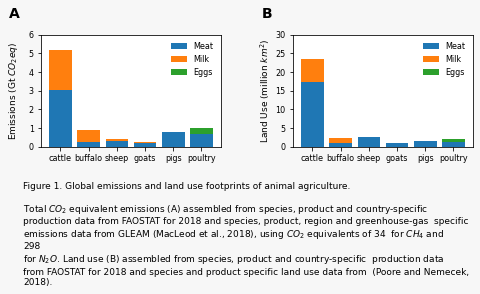

In [91]:
pdffile = "Figures/Figure1.pdf"

with PdfPages(pdffile) as pdf:    

    figh = 5.5
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

    panelw = 2.5
    panelh = panelw/1.61
    
    label_pos = -.115
    
    margin_top = 1
    
    panelx1 = 1.25
    panelx2 = 4.75
    panely = figh - margin_top - panelh
    
    ax = fig.add_axes([panelx1/figw,panely/figh,panelw/figw,panelh/figh])
    
    df = livestock_data.groupby('Category').sum()
    df['Emissions'] = df['Emissions|CO2'] + 34/1000 * df['Emissions|CH4'] + 298/1000 * df['Emissions|N2O']
    
    plot_species = ['cattle','buffalo','sheep','goats','pigs','poultry']
    plot_meat = np.array([
        df.loc['cattle_meat'].Emissions,
        df.loc['buffalo_meat'].Emissions,
        df.loc['sheep_meat'].Emissions,
        df.loc['goat_meat'].Emissions,
        df.loc['pig_meat'].Emissions,
        df.loc['chicken_meat'].Emissions + df.loc['duck_meat'].Emissions,
        ])

    plot_milk = np.array([
        df.loc['cow_milk'].Emissions,
        df.loc['buffalo_milk'].Emissions,
        df.loc['sheep_milk'].Emissions,
        df.loc['goat_milk'].Emissions,
        0,
        0,
    ])

    plot_eggs = np.array([
        0,
        0,
        0,
        0,
        0,
        df.loc['eggs'].Emissions,
    ])

    p1 = ax.bar(plot_species,plot_meat)
    p2 = ax.bar(plot_species,plot_milk,bottom=plot_meat)
    p3 = ax.bar(plot_species,plot_eggs,bottom=plot_meat + plot_milk)
    ax.set_ylabel(r'Emissions (Gt $CO_{2}eq$)', fontsize=9)
    ax.set_ylim(0,6)
    ax.legend((p1[0], p2[0], p3[0]), ('Meat', 'Milk','Eggs'), frameon=False)
    ax.text(label_pos,1.15,"A",transform=ax.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    ax.yaxis.set_label_coords(label_pos,0.5,transform=ax.transAxes)
    
    margin_between = 1
    
    #panelx = (figw - panelw)/2
    #panely -= panelh + margin_between
    
    ax = fig.add_axes([panelx2/figw,panely/figh,panelw/figw,panelh/figh])
    
    plot_species = ['cattle','buffalo','sheep','goats','pigs','poultry']
    plot_meat = np.array([
        df.loc['cattle_meat']['Land Use'],
        df.loc['buffalo_meat']['Land Use'],
        df.loc['sheep_meat']['Land Use'],
        df.loc['goat_meat']['Land Use'],
        df.loc['pig_meat']['Land Use'],
        df.loc['chicken_meat']['Land Use'] + df.loc['duck_meat']['Land Use'], 
    ])

    plot_milk = np.array([
        df.loc['cow_milk']['Land Use'],
        df.loc['buffalo_milk']['Land Use'],
        df.loc['sheep_milk']['Land Use'],
        df.loc['goat_milk']['Land Use'],
        0,
        0,
    ])

    plot_eggs = np.array([
        0,
        0,
        0,
        0,
        0,
        df.loc['eggs']['Land Use'],
    ])

    p1 = ax.bar(plot_species,plot_meat)
    p2 = ax.bar(plot_species,plot_milk,bottom=plot_meat)
    p3 = ax.bar(plot_species,plot_eggs,bottom=plot_meat + plot_milk)
    ax.set_ylabel(r'Land Use (million $km^2$)')
    ax.set_ylim(0,30)
    ax.legend((p1[0], p2[0], p3[0]), ('Meat', 'Milk','Eggs'), frameon=False)
    ax.text(label_pos,1.15,"B",transform=ax.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    ax.yaxis.set_label_coords(label_pos,0.5,transform=ax.transAxes)
    
    
    flh = r"Figure 1. Global emissions and land use footprints of animal agriculture."
    
    flt = r'''Total $CO_2$ equivalent emissions (A) assembled from species, product and country-specific 
production data from FAOSTAT for 2018 and species, product, region and greenhouse-gas 
specific emissions data from GLEAM (MacLeod et al., 2018), using $CO_2$ equivalents of 34 
for $CH_4$ and 298 for $N_{2}O$. Land use (B) assembled from species, product and country-specific 
production data from FAOSTAT for 2018 and species and product specific land use data from 
(Poore and Nemecek, 2018). 
'''
    
    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    
    pdf.savefig()
    
    plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    

## Figure 2 - Comparing Baseline, Phaseout of Bovids and Phaseout of all Livestock 

Function creates different versions for different subsets of data

In [92]:
def Figure2(plotname,plotlabel,plotcaption,scen,scenlabel,scen2="",scen2label=""):

    pdffile = "Figures/%s.pdf" % plotname

    with PdfPages(pdffile) as pdf:    

        figw = 8.5
        figh = 9.5

        fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

        panelw = 2
        panelh = panelw/1.61

        margin_top = 1
        margin_between = .75

        x = [1.5,7 - panelw]
        y = [figh - 1 - (i+1) * panelh - i * (margin_between) for i in [0,1,2,3]]

        ax = [[],[],[],[]]

        for j in [0,1,2]:
            for i in [0,1]:
                ax[j].append(fig.add_axes([x[i]/figw,y[j]/figh,panelw/figw,panelh/figh]))

        units = {
            'CO2' : "Gt/year",
            'CH4' : "Mt/year",
            'N2O' : "Mt/year"
        }

        pp_units = {
            'CO2' : "ppm",
            'CH4' : "ppb",
            'N2O' : "ppb"
        }


        factor = {
            'CO2' : 1,
            'CH4' : 1,
            'N2O' : 1
        }

        label_pos = -0.2
        
        r = scenarios.loc[2020:2100]
        
        for ai,gas in enumerate(gases):
            l1 = ax[ai][0].plot(r['Emissions|%s|BAU' % gas],c='red')
            l2 = ax[ai][0].plot(r['Emissions|%s|%s' % (gas,scen)],c='green')
            l3 = ""
            if scen2 != "":
                l3 = ax[ai][0].plot(r['Emissions|%s|%s' % (gas,scen2)],c='green',linestyle='dashed')
            ax[ai][1].plot(r['Concentration|%s|BAU' % gas],c='red')
            ax[ai][1].plot(r['Concentration|%s|%s' % (gas,scen)],c='green')
            if scen2 != "":
                ax[ai][1].plot(r['Concentration|%s|%s' % (gas,scen2)],c='green', linestyle='dashed')

            ax[ai][0].set_title("Emissions " + gas, fontsize=8)
            ax[ai][1].set_title("Atmospheric Concentration " + gas, fontsize=8)
            ax[ai][0].set_ylabel(units[gas],fontsize=8)
            ax[ai][0].set_ylim(0,)
            ax[ai][1].set_ylabel(pp_units[gas],fontsize=8)
            ax[ai][0].yaxis.set_label_coords(label_pos,0.5)
            ax[ai][1].yaxis.set_label_coords(label_pos,0.5)
            ax[ai][0].set_xlabel("Year",fontsize=8)
            ax[ai][1].set_xlabel("Year",fontsize=8)

        ax[0][0].text(label_pos,1.2,"A",transform=ax[0][0].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')
        ax[0][1].text(label_pos,1.2,"B",transform=ax[0][1].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')

        # Set tick font size

        for i in range(0,3):
            for j in range(0,2):
                for label in (ax[i][j].get_xticklabels() + ax[i][j].get_yticklabels()):
                    label.set_fontsize(8)

        for i in range(0,3):
            for j in range(0,2):
                ax[i][j].set_xlim(2020,2100)          


        legend_lines = [
            Line2D([0],[0],color='red', lw=2),
            Line2D([0],[0],color='green', lw=2),
        ]
        
        legend_labels = [
            'Business as Usual',
            scenlabel,
        ]
            
        if scen2 != "":
            legend_lines = [
                Line2D([0],[0],color='red', lw=2),
                Line2D([0],[0],color='green', lw=2, linestyle='dashed'),
                Line2D([0],[0],color='green', lw=2),
            ]
    
            legend_labels = [
                'Business as Usual',
                scen2label,
                scenlabel,
            ]


        plt.legend(legend_lines,legend_labels,bbox_to_anchor=(0,-.25), borderaxespad=0, frameon=False)

        flh = plotlabel

        flt = plotcaption 
        
        annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

        plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

        pdf.savefig()
        plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    

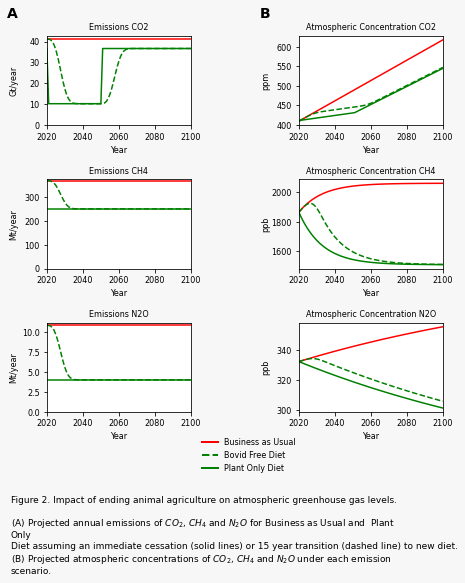

In [93]:
plotname = "Figure2"
plotlabel = r"Figure 2. Impact of ending animal agriculture on atmospheric greenhouse gas levels."
plotcaption = r'''(A) Projected annual emissions of CO2, CH4 and N2O for Business as Usual and 
Plant Only Diet assuming an immediate cessation (solid lines) or 15 year transition (dashed line) to new diet. 
(B) Projected atmospheric concentrations of CO2, CH4 and N2O under each emission 
scenario.'''

plotcaption = plotcaption.replace("CO2",r"$CO_2$")
plotcaption = plotcaption.replace("CH4",r"$CH_4$")
plotcaption = plotcaption.replace("N2O",r"$N_{2}O$")

scen = "Elimination"
scenlabel = "Plant Only Diet"
scen2 = "Phaseout"
scen2label = "Bovid Free Diet"


Figure2(plotname,plotlabel,plotcaption,scen,scenlabel,scen2,scen2label)

## RF

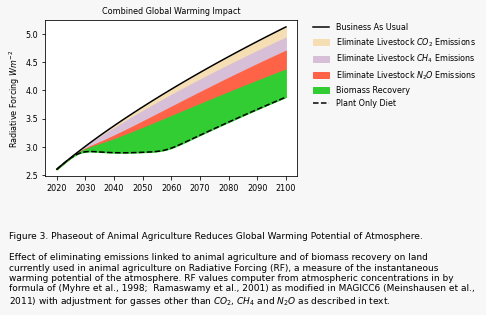

In [94]:
pdffile = "Figures/Figure3.pdf"

with PdfPages(pdffile) as pdf:    
    
    df = scenarios.loc[2020:2100]
    
    figw = 8.5
    figh = 6
    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

    panelw = 3.5
    panelh = panelw/1.61
    
    margin_top = 1.0

    panelx = 1.5
    panely = figh - margin_top - panelh
        
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    

    l1 = ax.plot(df.index,df['RFC|BAU'],color='black',label='Business as Usual')
    fb1 = ax.fill_between(df.index,df['RFC|BAU'],df['RFC|Phaseout_Breakdown_CO2'],label=r'Eliminate Livestock $CO_2$ Emissions',color='wheat')
    fb2 =ax.fill_between(df.index,df['RFC|Phaseout_Breakdown_CO2'],df['RFC|Phaseout_Breakdown_CO2_CH4'],label=r'Eliminate Livestock $CH_4$ Emissions',color='thistle')
    fb3 =ax.fill_between(df.index,df['RFC|Phaseout_Breakdown_CO2_CH4'],df['RFC|Phaseout_Breakdown_CO2_CH4_N2O'],label=r'Eliminate Livestock $N_{2}O$ Emissions',color='tomato')
    fb4 =ax.fill_between(df.index,df['RFC|Phaseout_Breakdown_CO2_CH4_N2O'],df['RFC|Phaseout'],label='Biomass Recovery',color='limegreen')
    l2 = ax.plot(df.index,df['RFC|Phaseout'],color='black',linestyle='dashed',label='Plant Only Diet')
    df = calib_scenarios.loc[2020:2100]
    #ax.plot(df['RFC|BAU_m28GT'],c='gray',linestyle='dashed',label=r'28Gt/year $CO_2$ reduction from BAU')
    ax.set_title("Combined Global Warming Impact", fontsize=8)

    ax.set_ylabel(r"Radiative Forcing $Wm^{-2}$",fontsize=8)       
    
    #ax.legend()
    
    ax.legend([l1[0],fb1,fb2,fb3,fb4,l2[0]],['Business As Usual',r'Eliminate Livestock $CO_2$ Emissions',r'Eliminate Livestock $CH_4$ Emissions',r'Eliminate Livestock $N_{2}O$ Emissions',
                                      'Biomass Recovery','Plant Only Diet'],bbox_to_anchor=(1.05,1.0), borderaxespad=0, frameon=False)
    
    flh = r"Figure 3. Phaseout of Animal Agriculture Reduces Global Warming Potential of Atmosphere."
    
    flt = r'''Effect of eliminating emissions linked to animal agriculture and of biomass recovery on land currently used
in animal agriculture on Radiative Forcing (RF), a measure of the instantaneous warming potential of the atmosphere.
RF values computer from atmospheric concentrations in by formula of (Myhre et al., 1998; 
Ramaswamy et al., 2001) as modified in MAGICC6 (Meinshausen et al., 2011) with adjustment for gasses other than
CO2, CH4 and N2O as described in text.'''
    
    flt = flt.replace("CO2",r"$CO_2$")
    flt = flt.replace("CH4",r"$CH_4$")
    flt = flt.replace("N2O",r"$N_{2}O$")

    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    pdf.savefig()
    plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    

## Figure 4 Carbon Opportunity for Eliminating Animal Ag

In [95]:
elcoc

,RF,ELCOC
Target,,
Baseline,5.130507,-0.00
Phaseout Bovids,4.256543,-1.41
Phaseout,3.881035,-1.95
Elimination,3.824883,-2.03
RF2.6,2.600000,-3.56
RF1.9,1.900000,-4.30


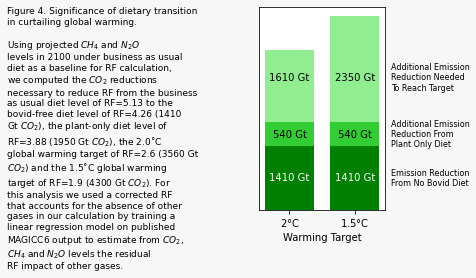

In [96]:
proj_end = scenarios.loc[2100]

pdffile = "Figures/Figure4.pdf"

with PdfPages(pdffile) as pdf:    
    
    figw = 8.5
    figh = 5

    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

   
    panelw = 1.75
    panelh = panelw * 1.61
    
    margin_top = 1

    panelx = 4.5
    panely = figh - margin_top - panelh
        
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])


    # Data from Figure 3-S1 below
    
    labels = [r'2$\degree$C','1.5$\degree$C']
    
    ec = -elcoc.loc['Phaseout']['ELCOC']
    plant = np.array([ec,ec])
    ec = -elcoc.loc['Phaseout Bovids']['ELCOC']
    nobo = np.array([ec,ec])
    ec1 = -elcoc.loc['RF2.6']['ELCOC']
    ec2 = -elcoc.loc['RF1.9']['ELCOC']
    rftarget = np.array([ec1,ec2])
    width=.75
    
    l1 = ax.bar(labels,1000 * rftarget,width=width,color='lightgreen',label="Additional Emission Reductions Required to Reach Warming Target")
    l2 = ax.bar(labels,1000 * plant,width=width,color='limegreen',label='Additional Emission Reductions From Plant Only Diet')
    l3 = ax.bar(labels,1000 * nobo,width=width,color='green',label='Emission Reductions From No Bovid Diet')
    
    #ax.set_ylabel(r"$CO_{2}$ Emissions Reductions Gt",fontsize=10)
    
    ax.set_xticks(np.arange(0,len(labels)))
    ax.set_xticklabels(labels,fontsize=10)
    #ax.legend(bbox_to_anchor=(1,1.25), borderaxespad=0,fontsize=9,frameon=False)
    #for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #    label.set_fontsize(8)
    ax.yaxis.set_label_coords(-1.5 * .075,0.5)
    ax.set_xlabel("Warming Target",fontsize=10)
    ax.set_yticklabels([])
    ax.set_yticks([])
    

# Add the patch to the Axes

    flh = "Figure 4. Significance of dietary transition\nin curtailing global warming."
    
    flt = r'''Using projected CH4 and N2O levels in 2100 under business as usual diet
as a baseline for RF calculation, we computed the CO2 reductions necessary
to reduce RF from the business as usual diet level of RF=%.2f to the bovid-free diet
level of RF=%.2f (%d Gt CO2), the plant-only diet level of RF=%.2f (%d Gt CO2),
the 2.0˚C global warming target of RF=2.6 (%d Gt CO2) and the 1.5˚C global warming
target of RF=1.9 (%d Gt CO2). For this analysis we used a corrected RF that accounts
for the absence of other gases in our calculation by training a linear
regression model on published MAGICC6 output to estimate from CO2, CH4 and N2O
levels the residual RF impact of other gases. ''' % (
        elcoc.loc['Baseline']['RF'],
        elcoc.loc['Phaseout Bovids']['RF'],
        -elcoc.loc['Phaseout Bovids']['ELCOC'] * 1000,
        elcoc.loc['Phaseout']['RF'],
        -elcoc.loc['Phaseout']['ELCOC'] * 1000,
        -elcoc.loc['RF2.6']['ELCOC'] * 1000,
        -elcoc.loc['RF1.9']['ELCOC'] * 1000,
    )
    
    flt = flt.replace("CO2",r"$CO_2$")
    flt = flt.replace("CH4",r"$CH_4$")
    flt = flt.replace("N2O",r"$N_{2}O$")

    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=40)

    plt.figtext(1/figw, (figh - 1)/figh, annot_txt, horizontalalignment='left', verticalalignment='top', fontsize=cap_fontsize, multialignment='left', wrap="True")    
    
    v1 = -elcoc.loc['Phaseout Bovids']['ELCOC'] * 1000
    h1 = v1/2
    
    ax.text(1.55,h1,"Emission Reduction\nFrom No Bovid Diet",fontsize=8, verticalalignment='center')
    #rect = patches.Rectangle((1.65,h1), .2, .1, clip_on = False, linewidth=0, facecolor='green')
    #ax.add_patch(rect)
    vlab = "%d Gt" % (v1)
    ax.text(0,h1,vlab,horizontalalignment='center',color='white',verticalalignment='center')
    ax.text(1,h1,vlab,horizontalalignment='center',color='white',verticalalignment='center')
    
    
    v2 = -elcoc.loc['Phaseout']['ELCOC'] * 1000
    h2 = v1 + 0.5 * (v2 - v1)
    
    ax.text(1.55,h2,"Additional Emission\nReduction From\nPlant Only Diet",fontsize=8, verticalalignment='center')
    #rect = patches.Rectangle((1.65,h2), .2, .1, clip_on = False, linewidth=0, facecolor='green')
    #ax.add_patch(rect)
    vlab = "%d Gt" % (v2 - v1)
    ax.text(0,h2,vlab,horizontalalignment='center',color='black',verticalalignment='center')
    ax.text(1,h2,vlab,horizontalalignment='center',color='black',verticalalignment='center')
    
    
    v3 = -elcoc.loc['RF2.6']['ELCOC'] * 1000
    v4 = -elcoc.loc['RF1.9']['ELCOC'] * 1000
    
    h3 = v2 + 0.25 * (v3 - v2) + 0.25 * (v4 - v2)
    
    ax.text(1.55,h3,"Additional Emission\nReduction Needed\nTo Reach Target",fontsize=8, verticalalignment='center')
    #rect = patches.Rectangle((1.65,h3), .2, .1, clip_on = False, linewidth=0, facecolor='green')
    #ax.add_patch(rect)
    vlab = "%d Gt" % (v3 - v2)
    ax.text(0,h3,vlab,horizontalalignment='center',color='black',verticalalignment='center')
    vlab = "%d Gt" % (v4 - v2)
    ax.text(1,h3,vlab,horizontalalignment='center',color='black',verticalalignment='center')
    
    pdf.savefig()
    plt.savefig(pdffile.replace('pdf','png'),dpi=300)

## Figure 5

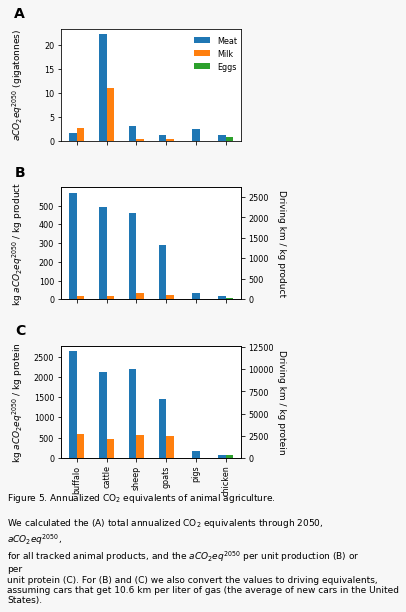

In [97]:
pdffile = "Figures/Figure5.pdf"

with PdfPages(pdffile) as pdf:    
    
    figw = 8.5
    figh = 10
    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

    panelw = 2.5
    panelh = panelw/1.61
    
    margin_top = 1
    
    panelx = 1.75
    panely = figh - margin_top - panelh
    
    panel_margin = .65
    
    bar_offset = .25
    bar_width = .25
    legend_x = .70
    label_x_offset = -.2
    
    bar_off_meat = np.array([-bar_width/2,-bar_width/2,-bar_width/2,-bar_width/2,0,-bar_width/2])
    bar_off_milk = np.array([bar_width/2,bar_width/2,bar_width/2,bar_width/2,0,0])
    bar_off_eggs = np.array([0,0,0,0,0,bar_width/2])
    
    r = scenarios.loc[2050]
    plot_species = ['buffalo','cattle','sheep','goats','pigs','chicken']

    x_labels = ['buffalo','cattle','sheep','goats','pigs','chicken']
    x_coords = np.array([1,2,3,4,5,6])

    axA = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])

    meat_data = [
        r['ACO2EQ|Elimination|buffalo_meat'],
        r['ACO2EQ|Elimination|cattle_meat'],
        r['ACO2EQ|Elimination|sheep_meat'],
        r['ACO2EQ|Elimination|goat_meat'],
        r['ACO2EQ|Elimination|pig_meat'],
        r['ACO2EQ|Elimination|chicken_meat']
    ]
    meat_data = np.array(meat_data)
    
    milk_data = [
        r['ACO2EQ|Elimination|buffalo_milk'],
        r['ACO2EQ|Elimination|cow_milk'],
        r['ACO2EQ|Elimination|sheep_milk'],
        r['ACO2EQ|Elimination|goat_milk'],
        0,
        0
    ]
    milk_data = np.array(milk_data)
    
    egg_data = [
        0,
        0,
        0,
        0,
        0,
        r['ACO2EQ|Elimination|eggs'],
    ]
    egg_data = np.array(egg_data)
    
    pA1 = axA.bar(x_coords + bar_off_meat,meat_data,width=bar_width,label='meat')
    pA2 = axA.bar(x_coords + bar_off_milk,milk_data,width=bar_width,label='milk')
    pA3 = axA.bar(x_coords + bar_off_eggs,egg_data,width=bar_width,label='eggs')
    
    axA.set_ylabel(r'$aCO_2eq^{2050}$ (gigatonnes)')
    axA.text(label_x_offset,1.1,"A",transform=axA.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axA.set_xticks([1,2,3,4,5,6])
    axA.set_xticklabels([])
    axA.yaxis.set_label_coords(label_x_offset,0.5,transform=axA.transAxes)
    axA.legend((pA1[0], pA2[0], pA3[0]), ('Meat', 'Milk','Eggs'), loc='upper left', frameon=False, bbox_to_anchor=(legend_x,1.0))

    panely -= panelh + panel_margin
    
    axB = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    meat_data = [
        r['EI_perunit|Elimination|buffalo_meat'],
        r['EI_perunit|Elimination|cattle_meat'],
        r['EI_perunit|Elimination|sheep_meat'],
        r['EI_perunit|Elimination|goat_meat'],
        r['EI_perunit|Elimination|pig_meat'],
        r['EI_perunit|Elimination|chicken_meat']
    ]
    meat_data = np.array(meat_data)
    
    milk_data = [
        r['EI_perunit|Elimination|buffalo_milk'],
        r['EI_perunit|Elimination|cow_milk'],
        r['EI_perunit|Elimination|sheep_milk'],
        r['EI_perunit|Elimination|goat_milk'],
        0,
        0
    ]
    milk_data = np.array(milk_data)
    
    egg_data = [
        0,
        0,
        0,
        0,
        0,
        r['EI_perunit|Elimination|eggs'],
    ]
    egg_data = np.array(egg_data)
    
    
    pB1 = axB.bar(x_coords + bar_off_meat,meat_data,width=bar_width,label='meat')
    pB2 = axB.bar(x_coords + bar_off_milk,milk_data,width=bar_width,label='milk')
    pB3 = axB.bar(x_coords + bar_off_eggs,egg_data,width=bar_width,label='eggs')
    
    axB.set_ylabel(r'kg $aCO_2eq^{2050}$ / kg product')
    #axA.set_ylim(0,1.0)
    axB.text(label_x_offset,1.1,"B",transform=axB.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axB.set_xticks([1,2,3,4,5,6])
    axB.set_xticklabels([])
    axB.yaxis.set_label_coords(label_x_offset,0.5,transform=axB.transAxes)
    #axB.legend((pB1[0], pB2[0], pB3[0]), ('Meat', 'Milk','Eggs'), loc='upper left', frameon=False, bbox_to_anchor=(legend_x,1.0))
    
    axBt = axB.twinx()
    ymin = 0
    ymax = axB.get_ylim()[1]
    conv = (1.61 * 25) / 8.8  
    axBt.set_ylim(ymin,ymax*conv)
    axBt.set_ylabel(r'Driving km / kg product',rotation=-90)
    axBt.yaxis.set_label_coords(1.25,0.5,transform=axBt.transAxes)
    panely -= panelh + panel_margin
    
    axC = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    meat_data = [
        r['EI_perprotein|Elimination|buffalo_meat'],
        r['EI_perprotein|Elimination|cattle_meat'],
        r['EI_perprotein|Elimination|sheep_meat'],
        r['EI_perprotein|Elimination|goat_meat'],
        r['EI_perprotein|Elimination|pig_meat'],
        r['EI_perprotein|Elimination|chicken_meat']
    ]
    meat_data = np.array(meat_data)
    
    milk_data = [
        r['EI_perprotein|Elimination|buffalo_milk'],
        r['EI_perprotein|Elimination|cow_milk'],
        r['EI_perprotein|Elimination|sheep_milk'],
        r['EI_perprotein|Elimination|goat_milk'],
        0,
        0
    ]
    milk_data = np.array(milk_data)
    
    egg_data = [
        0,
        0,
        0,
        0,
        0,
        r['EI_perprotein|Elimination|eggs'],
    ]
    egg_data = np.array(egg_data)    
    pC1 = axC.bar(x_coords + bar_off_meat,meat_data,width=bar_width,label='meat')
    pC2 = axC.bar(x_coords + bar_off_milk,milk_data,width=bar_width,label='milk')
    pC3 = axC.bar(x_coords + bar_off_eggs,egg_data,width=bar_width,label='eggs')
    
    axC.set_ylabel(r'kg $aCO_2eq^{2050}$ / kg protein')
    #axA.set_ylim(0,1.0)
    axC.text(label_x_offset,1.1,"C",transform=axC.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axC.set_xticks([1,2,3,4,5,6])
    axC.set_xticklabels([])
    axC.yaxis.set_label_coords(label_x_offset,0.5,transform=axC.transAxes)
    #axC.legend((pC1[0], pC2[0], pC3[0]), ('Meat', 'Milk','Eggs'), loc='upper left', frameon=False, bbox_to_anchor=(legend_x,1.0))
    
    axCt = axC.twinx()
    ymin = 0
    ymax = axC.get_ylim()[1]
    conv = (1.61 * 25) / 8.8  
    axCt.set_ylim(ymin,ymax*conv)
    axCt.set_ylabel(r'Driving km / kg protein',rotation=-90)
    axCt.yaxis.set_label_coords(1.25,0.5,transform=axCt.transAxes)
    panely -= panelh + panel_margin        
    axC.set_xticklabels(x_labels,rotation=90)
    
    flh = r"Figure 5. Annualized CO$_2$ equivalents of animal agriculture."
    
    flt = r'''We calculated the (A) total annualized CO$_2$ equivalents through 2050, $aCO_2eq^{2050}$, 
for all tracked animal products, and the $aCO_2eq^{2050}$ per unit production (B) or per unit protein (C).
For (B) and (C) we also convert the values to driving equivalents, assuming cars that get 10.6 km per liter of gas
(the average of new cars in the United States).'''
    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=90)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    
    pdf.savefig()
    plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    
    

## Figure 6 

In [98]:
dfp['SSP'] = dfp.Scenario.apply(lambda x: x.split('-')[0])
dfp['SSP-TARGET'] = dfp.Scenario.apply(lambda x: x.split('-')[1])

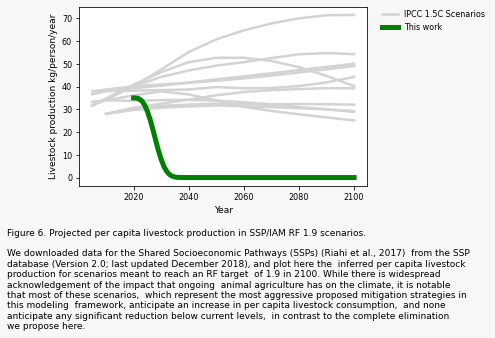

In [99]:
pdffile = "Figures/Figure6.pdf"

with PdfPages(pdffile) as pdf:    
    
    figw = 8.5
    figh = 6.5
    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

    panelw = 4
    panelh = panelw/1.61
    
    margin_top = 1
    
    panelx = 2.0
    panely = figh - margin_top - panelh
    
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    
    dfpw19 = dfp[(dfp.Region == "World") & (dfp['SSP-TARGET'] == '19')].copy()
    dfpw19.Year = dfpw19.Year.astype('int64')
    for i,r in dfpw19.groupby(['Model','Scenario']):
        ax.plot(r.Year,1e+3 * r['Agricultural Production|Livestock']/r['Population'],c='lightgrey',linewidth=2.5)
    
    r = scenarios.loc[2020:2100]
    ax.plot(r.aa_exponential_phaseout * 35, c='green', linewidth = 5)
    
    ax.set_xticks([2020,2040,2060,2080,2100])
    ax.set_xlabel("Year")
    ax.set_ylabel("Livestock production kg/person/year")
    
    legend_lines = [
        Line2D([0],[0],color='lightgrey', lw=2.5),
        Line2D([0],[0],color='green', lw=5),
    ]

    legend_labels = [
        'IPCC 1.5C Scenarios',
        'This work',
    ]

    plt.legend(legend_lines,legend_labels,bbox_to_anchor=(1.04,1.0), borderaxespad=0, frameon=False)

    
    flh = "Figure 6. Projected per capita livestock production in SSP/IAM RF 1.9 scenarios."
    
    flt = '''\
    We downloaded data for the Shared Socioeconomic Pathways (SSPs) (Riahi et al., 2017) 
    from the SSP database (Version 2.0; last updated December 2018), and plot here the 
    inferred per capita livestock production for scenarios meant to reach an RF target 
    of 1.9 in 2100. While there is widespread acknowledgement of the impact that ongoing 
    animal agriculture has on the climate, it is notable that most of these scenarios, 
    which represent the most aggressive proposed mitigation strategies in this modeling 
    framework, anticipate an increase in per capita livestock consumption, 
    and none anticipate any significant reduction below current levels, 
    in contrast to the complete elimination we propose here.
    '''
    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")
        
    pdf.savefig()
    plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    
    
    
    




# Supplemental Figures

## Figure 1-S1 - Animal Ag Emissions and Gas and Species

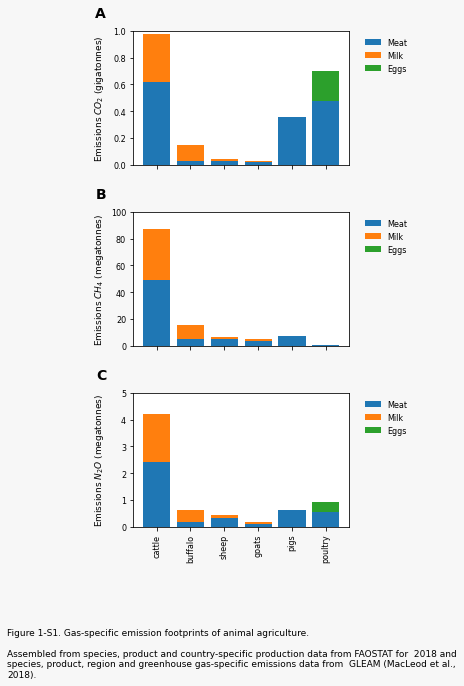

In [100]:
pdffile = "Figures/Figure1-S1.pdf"

with PdfPages(pdffile) as pdf:    
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

    panelw = 3
    panelh = panelw/1.61
    
    margin_top = 1
    
    panelx = (figw - panelw)/2
    panely = figh - margin_top - panelh
    
    panel_margin = .65
    
    df = livestock_data.groupby('Category').sum()
    plot_species = ['cattle','buffalo','sheep','goats','pigs','poultry']
    
    axA = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    c = "Emissions|CO2" 

    plot_meat = np.array([
        df.loc['cattle_meat'][c],
        df.loc['buffalo_meat'][c],
        df.loc['sheep_meat'][c],
        df.loc['goat_meat'][c],
        df.loc['pig_meat'][c],
        df.loc['chicken_meat'][c] + df.loc['duck_meat'][c],
    ])

    plot_milk = np.array([
        df.loc['cow_milk'][c],
        df.loc['buffalo_milk'][c],
        df.loc['sheep_milk'][c],
        df.loc['goat_milk'][c],
        0,
        0,
    ])

    plot_eggs = np.array([
        0,
        0,
        0,
        0,
        0,
        df.loc['eggs'][c],
    ])

    pA1 = axA.bar(plot_species,plot_meat)
    pA2 = axA.bar(plot_species,plot_milk,bottom=plot_meat)
    pA3 = axA.bar(plot_species,plot_eggs,bottom=plot_meat + plot_milk)
    axA.set_ylabel(r"Emissions $CO_{2}$ (gigatonnes)")
    axA.set_ylim(0,1.0)
    axA.text(-.125,1.1,"A",transform=axA.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axA.set_xticks(np.arange(0,len(plot_species)))
    axA.set_xticklabels([])
    axA.yaxis.set_label_coords(-0.125,0.5,transform=axA.transAxes)
    axA.legend((pA1[0], pA2[0], pA3[0]), ('Meat', 'Milk','Eggs'), loc='upper left', frameon=False, bbox_to_anchor=(1.04,1.0))

    panely -= panelh + panel_margin
    
    axB = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    c = "Emissions|CH4" 

    plot_meat = np.array([
        df.loc['cattle_meat'][c],
        df.loc['buffalo_meat'][c],
        df.loc['sheep_meat'][c],
        df.loc['goat_meat'][c],
        df.loc['pig_meat'][c],
        df.loc['chicken_meat'][c] + df.loc['duck_meat'][c],
    ])

    plot_milk = np.array([
        df.loc['cow_milk'][c],
        df.loc['buffalo_milk'][c],
        df.loc['sheep_milk'][c],
        df.loc['goat_milk'][c],
        0,
        0,
    ])

    plot_eggs = np.array([
        0,
        0,
        0,
        0,
        0,
        df.loc['eggs'][c],
    ])

    pB1 = axB.bar(plot_species,plot_meat)
    pB2 = axB.bar(plot_species,plot_milk,bottom=plot_meat)
    pB3 = axB.bar(plot_species,plot_eggs,bottom=plot_meat + plot_milk)
    axB.set_ylabel(r"Emissions $CH_{4}$ (megatonnes)")
    axB.set_ylim(0,100)
    axB.text(-.125,1.1,"B",transform=axB.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axB.set_xticks(np.arange(0,len(plot_species)))
    axB.set_xticklabels([])
    axB.yaxis.set_label_coords(-0.125,0.5)
    axB.legend((pB1[0], pB2[0], pB3[0]), ('Meat', 'Milk','Eggs'), loc='upper left',frameon=False,bbox_to_anchor=(1.04,1.0))
   
    
    panely -= panelh + panel_margin
    
    axC = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    c = "Emissions|N2O" 

    plot_meat = np.array([
        df.loc['cattle_meat'][c],
        df.loc['buffalo_meat'][c],
        df.loc['sheep_meat'][c],
        df.loc['goat_meat'][c],
        df.loc['pig_meat'][c],
        df.loc['chicken_meat'][c] + df.loc['duck_meat'][c],
    ])

    plot_milk = np.array([
        df.loc['cow_milk'][c],
        df.loc['buffalo_milk'][c],
        df.loc['sheep_milk'][c],
        df.loc['goat_milk'][c],
        0,
        0,
    ])

    plot_eggs = np.array([
        0,
        0,
        0,
        0,
        0,
        df.loc['eggs'][c],
    ])

    p1 = axC.bar(plot_species,plot_meat)
    p2 = axC.bar(plot_species,plot_milk,bottom=plot_meat)
    p3 = axC.bar(plot_species,plot_eggs,bottom=plot_meat + plot_milk)
    axC.set_ylabel(r"Emissions $N_{2}O$ (megatonnes)")
    axC.set_ylim(0,5)
    axC.text(-.125,1.1,"C",transform=axC.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axC.set_xticks(np.arange(0,len(plot_species)))
    axC.set_xticklabels(plot_species,rotation=90)
    axC.yaxis.set_label_coords(-0.125,0.5)
    axC.legend((p1[0], p2[0], p3[0]), ('Meat', 'Milk','Eggs'), loc='upper left', frameon=False, bbox_to_anchor=(1.04,1.0))            
        
    
    flh = r"Figure 1-S1. Gas-specific emission footprints of animal agriculture."
    
    flt = r'''Assembled from species, product and country-specific production data from FAOSTAT for 
2018 and species, product, region and greenhouse gas-specific emissions data from 
GLEAM (MacLeod et al., 2018).'''
    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    
    pdf.savefig()
    plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    
    

In [101]:
def Figure2_Supp(plotname,plotlabel,plotcaption,scen,scenlabel,scen2="",scen2label=""):

    pdffile = "Figures/%s.pdf" % plotname

    with PdfPages(pdffile) as pdf:    

        figw = 8.5
        figh = 11

        fig = plt.figure(figsize = (figw,figh))

        panelw = 2
        panelh = panelw/1.61

        margin_top = 1
        margin_between = .75

        x = [1.5,7 - panelw]
        y = [figh - 1 - (i+1) * panelh - i * (margin_between) for i in [0,1,2,3]]

        ax = [[],[],[],[]]

        for j in [0,1,2,3]:
            for i in [0,1]:
                ax[j].append(fig.add_axes([x[i]/figw,y[j]/figh,panelw/figw,panelh/figh]))

        units = {
            'CO2' : "Gt/year",
            'CH4' : "Mt/year",
            'N2O' : "Mt/year"
        }

        pp_units = {
            'CO2' : "ppm",
            'CH4' : "ppb",
            'N2O' : "ppb"
        }


        factor = {
            'CO2' : 1,
            'CH4' : 1,
            'N2O' : 1
        }

        label_pos = -0.2
        
        r = scenarios.loc[2020:2100]
        
        for ai,gas in enumerate(gases):
            l1 = ax[ai][0].plot(r['Emissions|%s|BAU' % gas],c='red')
            l2 = ax[ai][0].plot(r['Emissions|%s|%s' % (gas,scen)],c='green')
            l3 = ""
            if scen2 != "":
                l3 = ax[ai][0].plot(r['Emissions|%s|%s' % (gas,scen2)],c='green',linestyle='dashed')
            ax[ai][1].plot(r['Concentration|%s|BAU' % gas],c='red')
            ax[ai][1].plot(r['Concentration|%s|%s' % (gas,scen)],c='green')
            if scen2 != "":
                ax[ai][1].plot(r['Concentration|%s|%s' % (gas,scen2)],c='green', linestyle='dashed')

            ax[ai][0].set_title("Emissions " + gas, fontsize=8)
            ax[ai][1].set_title("Atmospheric Concentration " + gas, fontsize=8)
            ax[ai][0].set_ylabel(units[gas],fontsize=8)
            ax[ai][0].set_ylim(0,)
            ax[ai][1].set_ylabel(pp_units[gas],fontsize=8)
            ax[ai][0].yaxis.set_label_coords(label_pos,0.5)
            ax[ai][1].yaxis.set_label_coords(label_pos,0.5)
            ax[ai][0].set_xlabel("Year",fontsize=8)
            ax[ai][1].set_xlabel("Year",fontsize=8)

        ax[3][1].plot(r['RF|BAU'],c='red')
        ax[3][1].plot(r['RF|%s' %scen],c='green')
        if scen2 != "":
            ax[3][1].plot(r['RF|%s' %scen2],c='green',linestyle='dashed')
        ax[3][1].set_title("Combined Global Warming Impact", fontsize=8)
        ax[3][1].yaxis.set_label_coords(label_pos,0.5)

        ax[0][0].text(label_pos,1.2,"A",transform=ax[0][0].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')
        ax[0][1].text(label_pos,1.2,"B",transform=ax[0][1].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')
        ax[3][1].text(label_pos,1.2,"C",transform=ax[3][1].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')

        # Set tick font size

        for i in range(0,4):
            for j in range(0,2):
                for label in (ax[i][j].get_xticklabels() + ax[i][j].get_yticklabels()):
                    label.set_fontsize(8)

        for i in range(0,4):
            for j in range(0,2):
                ax[i][j].set_xlim(2020,2100)

        ax[3][0].set_visible(False)
        ax[3][1].set_ylabel(r"Radiative Forcing $Wm^{-2}$",fontsize=8)                


        legend_lines = [
            Line2D([0],[0],color='red', lw=2),
            Line2D([0],[0],color='green', lw=2),
        ]
        
        legend_labels = [
            'Business as Usual',
            scenlabel,
        ]
            
        if scen2 != "":
            legend_lines = [
                Line2D([0],[0],color='red', lw=2),
                Line2D([0],[0],color='green', lw=2, linestyle='dashed'),
                Line2D([0],[0],color='green', lw=2),
            ]
    
            legend_labels = [
                'Business as Usual',
                scen2label,
                scenlabel,
            ]


        plt.legend(legend_lines,legend_labels,bbox_to_anchor=(-.75,.5), borderaxespad=0, frameon=False)

        flh = plotlabel

        flt = plotcaption 
        
        annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

        plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

        pdf.savefig()
        plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    

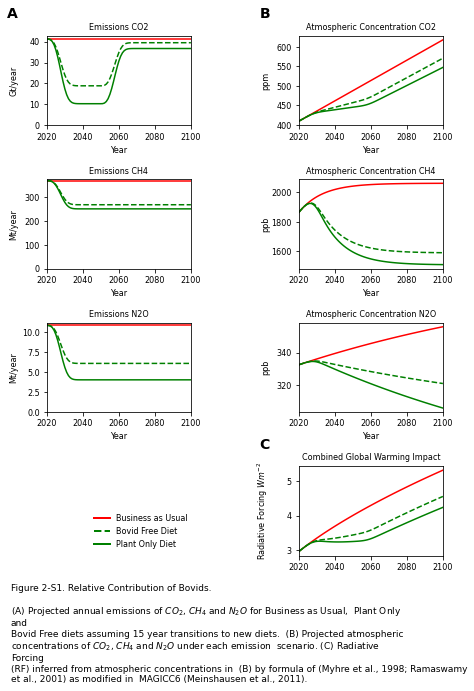

In [102]:
plotname = "Figure2-S1"
plotlabel = r"Figure 2-S1. Relative Contribution of Bovids."
plotcaption = r'''(A) Projected annual emissions of CO2, CH4 and N2O for Business as Usual, 
Plant Only and Bovid Free diets assuming 15 year transitions to new diets. 
(B) Projected atmospheric concentrations of CO2, CH4 and N2O under each emission 
scenario. (C) Radiative Forcing (RF) inferred from atmospheric concentrations in 
(B) by formula of (Myhre et al., 1998; Ramaswamy et al., 2001) as modified in 
MAGICC6 (Meinshausen et al., 2011).'''

plotcaption = plotcaption.replace("CO2",r"$CO_2$")
plotcaption = plotcaption.replace("CH4",r"$CH_4$")
plotcaption = plotcaption.replace("N2O",r"$N_{2}O$")

scen = "Phaseout"
scenlabel = "Plant Only Diet"
scen2 = "Phaseout|Bovid"
scen2label = "Bovid Free Diet"


Figure2_Supp(plotname,plotlabel,plotcaption,scen,scenlabel,scen2,scen2label)


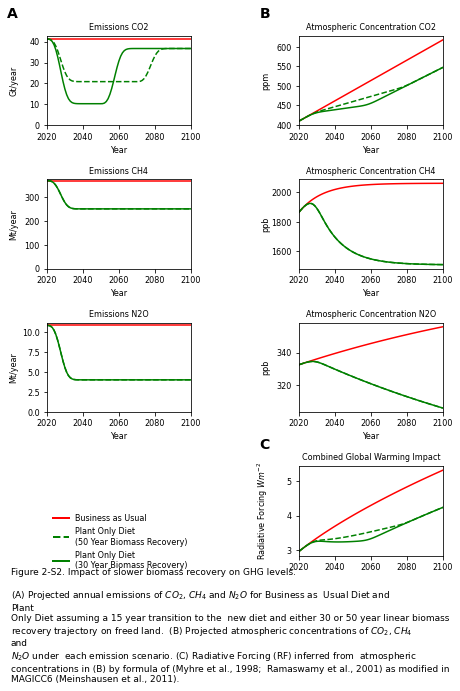

In [103]:
plotname = "Figure2-S2"
plotlabel = r"Figure 2-S2. Impact of slower biomass recovery on GHG levels."
plotcaption = r'''(A) Projected annual emissions of CO2, CH4 and N2O for Business as 
Usual Diet and Plant Only Diet assuming a 15 year transition to the 
new diet and either 30 or 50 year linear biomass recovery trajectory on freed land. 
(B) Projected atmospheric concentrations of CO2, CH4 and N2O under 
each emission scenario. (C) Radiative Forcing (RF) inferred from 
atmospheric concentrations in (B) by formula of (Myhre et al., 1998; 
Ramaswamy et al., 2001) as modified in MAGICC6 (Meinshausen et al., 2011).'''
scen = "Phaseout"
scenlabel = "Plant Only Diet\n(30 Year Biomass Recovery)"
scen2 = "Phaseout|Slow Recovery"
scen2label = "Plant Only Diet\n(50 Year Biomass Recovery)"
plotcaption = plotcaption.replace("CO2",r"$CO_2$")
plotcaption = plotcaption.replace("CH4",r"$CH_4$")
plotcaption = plotcaption.replace("N2O",r"$N_{2}O$")

Figure2_Supp(plotname,plotlabel,plotcaption,scen,scenlabel,scen2,scen2label)


#### Figure 4-S1

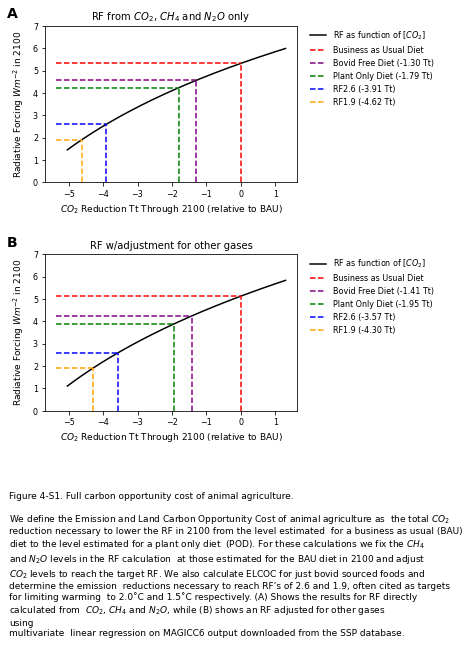

In [104]:
proj_end = scenarios.loc[2100]

pdffile = "Figures/Figure4-S1.pdf"

with PdfPages(pdffile) as pdf:    
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh))

    panelw = 3.5
    panelh = panelw/1.61
    
    margin_top = 1.5

    panelx = 1.5
    panely = figh - margin_top - panelh
        
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    
    ax.set_ylim(0,7)
    
    xl = 300
    xh = 700
    x = np.linspace(xl,xh,500)

    CB = proj_end['Concentration|CO2|BAU']
    MB = proj_end['Concentration|CH4|BAU']
    NB = proj_end['Concentration|N2O|BAU']

    xd = x - CB
    xe = 2 * xd * 44 * 1.8E11 / 1E12 / 1000
    (x_C,x_M,x_N,x_R) = RF_MAGICC(x,MB,NB)

    ax.plot(xe,x_R,label=r'RF as function of [$CO_{2}$]',c='black')
    px = plt.xlim()
    py = plt.ylim()

    xn = xe[np.argmin(np.abs(x_R-proj_end['RF|BAU']))]
    ax.plot([px[0],xn],[proj_end['RF|BAU'],proj_end['RF|BAU']],c='red',label='Business as Usual Diet',linestyle='dashed')
    ax.plot([xn,xn],[py[0],proj_end['RF|BAU']],c='red',linestyle='dashed')
    
    rft = proj_end['RF|Phaseout|Bovid']
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='purple',label='Bovid Free Diet (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='purple',linestyle='dashed')
    
    rft = proj_end['RF|Phaseout']
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='green',label='Plant Only Diet (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='green',linestyle='dashed')

    rft = 2.6
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='blue',label='RF2.6 (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='blue',linestyle='dashed')

    rft = 1.9
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='orange',label='RF1.9 (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='orange',linestyle='dashed')
    ax.legend(bbox_to_anchor=(1.04,1), borderaxespad=0,frameon=False)
    ax.set_xlabel(r"$CO_{2}$ Reduction Tt Through 2100 (relative to BAU)")
    ax.set_ylabel(r"Radiative Forcing $Wm^{-2}$ in 2100")    
    ax.yaxis.set_label_coords(-0.075,0.5)

    ax.text(-.15,1.05,"A",transform=ax.transAxes,fontsize=14,fontweight='bold')
    title = r"RF from $CO_2$, $CH_4$ and $N_{2}O$ only"
    ax.set_title(title)
    
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(8)

    
    panely = figh - margin_top - panelh - 1.0 - panelh
    
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    
    ax.set_ylim(0,7)
    
    xl = 300
    xh = 700
    x = np.linspace(xl,xh,1000)

    CB = proj_end['Concentration|CO2|BAU']
    MB = proj_end['Concentration|CH4|BAU']
    NB = proj_end['Concentration|N2O|BAU']

    xd = x - CB
    xe = 2 * xd * 44 * 1.8E11 / 1E12 / 1000
    x_R = RF_cMAGICC(x,MB,NB)

    ax.plot(xe,x_R,label=r'RF as function of [$CO_{2}$]',c='black')
    px = plt.xlim()
    py = plt.ylim()

    xn = xe[np.argmin(np.abs(x_R-proj_end['RFC|BAU']))]
    ax.plot([px[0],xn],[proj_end['RFC|BAU'],proj_end['RFC|BAU']],c='red',label='Business as Usual Diet',linestyle='dashed')
    ax.plot([xn,xn],[py[0],proj_end['RFC|BAU']],c='red',linestyle='dashed')
    
    rft = proj_end['RFC|Phaseout|Bovid']
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='purple',label='Bovid Free Diet (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='purple',linestyle='dashed')
    
    rft = proj_end['RFC|Phaseout']
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='green',label='Plant Only Diet (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='green',linestyle='dashed')

    rft = 2.6
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='blue',label='RF2.6 (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='blue',linestyle='dashed')

    rft = 1.9
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='orange',label='RF1.9 (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='orange',linestyle='dashed')
    ax.legend(bbox_to_anchor=(1.04,1), borderaxespad=0,frameon=False)
    ax.set_xlabel(r"$CO_{2}$ Reduction Tt Through 2100 (relative to BAU)")
    ax.set_ylabel(r"Radiative Forcing $Wm^{-2}$ in 2100")    
    ax.yaxis.set_label_coords(-0.075,0.5)
    
    ax.text(-.15,1.05,"B",transform=ax.transAxes,fontsize=14,fontweight='bold')
    ax.set_title("RF w/adjustment for other gases")
    
    #for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #    label.set_fontsize(8)
    
    flh = r"Figure 4-S1. Full carbon opportunity cost of animal agriculture."
    
    flt = r'''We define the Emission and Land Carbon Opportunity Cost of animal agriculture as 
the total CO2 reduction necessary to lower the RF in 2100 from the level estimated 
for a business as usual (BAU) diet to the level estimated for a plant only diet 
(POD). For these calculations we fix the CH4 and N2O levels in the RF calculation 
at those estimated for the BAU diet in 2100 and adjust CO2 levels to reach the target RF.
We also calculate ELCOC for just bovid sourced foods and determine the emission 
reductions necessary to reach RF’s of 2.6 and 1.9, often cited as targets for limiting warming 
to 2.0˚C and 1.5˚C respectively. (A) Shows the results for RF directly calculated from 
CO2, CH4 and N2O, while (B) shows an RF adjusted for other gases using multivariate 
linear regression on MAGICC6 output downloaded from the SSP database.'''
    
    flt = flt.replace("CO2",r"$CO_2$")
    flt = flt.replace("CH4",r"$CH_4$")
    flt = flt.replace("N2O",r"$N_{2}O$")

    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    pdf.savefig()
    plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    